# <p style="padding:20px;background-color:#ffe7a0;margin:0;color:(0,0,0);font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 20px;overflow:hidden;font-weight:900">FORECASTING CPI IN VIETNAM WITH DEEP LEARNING</p>

[Colab Phân tích dữ liệu CPI](https://colab.research.google.com/drive/1sk5R96sxV-vFseH_W-plp89qYPgioj45?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries and Data Loading

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = "/content/drive/MyDrive/University/Năm 3_HK2/Phương pháp nghiên cứu khoa học /cpi/cpi_processed.csv"

data = pd.read_csv(path)
data['date'] = pd.to_datetime(data['time'])
data.drop('time', axis=1, inplace=True)
data.drop('cpi_mom', axis=1, inplace=True)
data['cpi'] = data['cpi_yoy'].astype(float)
data.drop('cpi_yoy', axis=1, inplace=True)
data.set_index('date', inplace=True)
data.head()

cpi
date              
1995-12-01  112.91
1996-01-01  109.76
1996-02-01  108.80
1996-03-01  109.46
1996-04-01  108.48

In [ ]:
data.tail()

cpi
date              
2024-08-01  103.47
2024-09-01  102.66
2024-10-01  102.91
2024-11-01  102.79
2024-12-01  102.96

In [ ]:
data.to_csv('/content/drive/MyDrive/University/Năm 3_HK2/Phương pháp nghiên cứu khoa học /cpi/cpi_yoy.csv')

## 2. Phân tích biến CPI

In [ ]:
# Split the data into train and test sets
des = data.loc['1995-01':'2024-12']
des.tail()

cpi
date              
2024-08-01  103.47
2024-09-01  102.66
2024-10-01  102.91
2024-11-01  102.79
2024-12-01  102.96

In [ ]:
# 1. Thống kê mô tả
descriptive_stats = des['cpi'].describe()

# 2. Kiểm tra độ lệch và độ nhọn
skewness = des['cpi'].skew()
kurtosis = des['cpi'].kurt()

# Hiển thị kết quả
results = {
    "Descriptive Statistics": descriptive_stats,
    "Skewness": skewness,
    "Kurtosis": kurtosis
}

results

{'Descriptive Statistics': count    349.000000
 mean     105.688883
 std        5.404596
 min       97.400000
 25%      102.630000
 50%      104.310000
 75%      107.620000
 max      128.200000
 Name: cpi, dtype: float64,
 'Skewness': np.float64(1.8811054211799776),
 'Kurtosis': np.float64(4.348543215311134)}

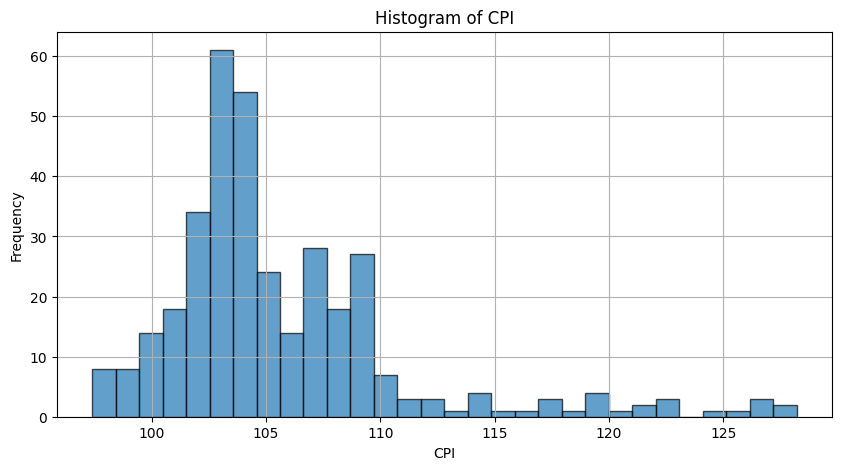

In [ ]:
# 2. Histogram (Phân phối dữ liệu)
plt.figure(figsize=(10, 5))
plt.hist(des['cpi'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Histogram of CPI')
plt.xlabel('CPI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show();

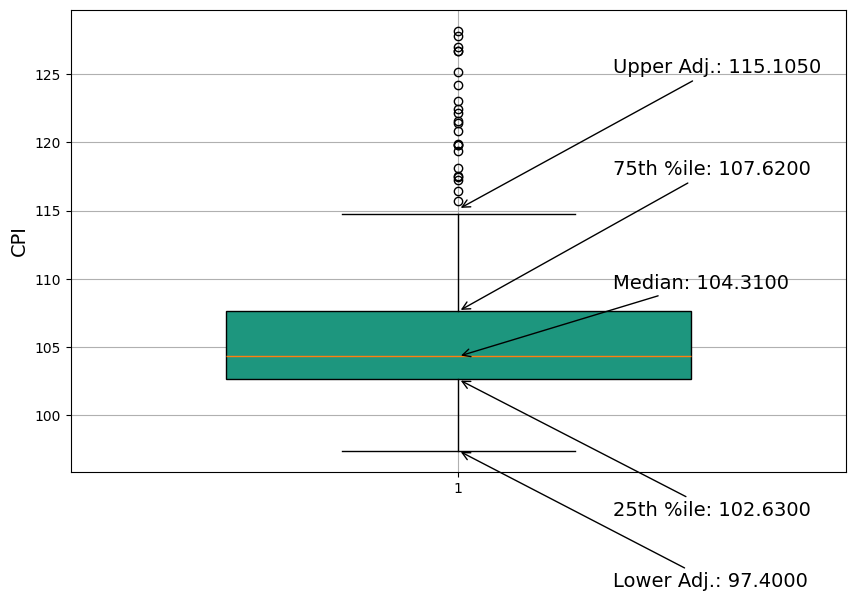

In [ ]:
dff = des['cpi'].dropna()  # Ensure no NaN values
median = np.median(dff)
q1 = np.percentile(dff, 25)
q3 = np.percentile(dff, 75)
iqr = q3 - q1
lower_adj = max(min(dff), q1 - 1.5 * iqr)
upper_adj = min(max(dff), q3 + 1.5 * iqr)

# Now, the plotting code will work
plt.figure(figsize=(10, 6))

# Plot the boxplot
box = plt.boxplot(dff, patch_artist=True, widths=0.6, showmeans=False)
plt.ylabel('CPI', fontsize=14)

# Style boxplot with orange color
for patch in box['boxes']:
    patch.set_facecolor('#1d967e')

# Adding annotations with larger font size
plt.annotate(f"Median: {median:.4f}", xy=(1, median), xytext=(1.2, median + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')
plt.annotate(f"25th %ile: {q1:.4f}", xy=(1, q1), xytext=(1.2, q1 - 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')
plt.annotate(f"75th %ile: {q3:.4f}", xy=(1, q3), xytext=(1.2, q3 + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')
plt.annotate(f"Lower Adj.: {lower_adj:.4f}", xy=(1, lower_adj), xytext=(1.2, lower_adj - 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')
plt.annotate(f"Upper Adj.: {upper_adj:.4f}", xy=(1, upper_adj), xytext=(1.2, upper_adj + 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=14, ha='left')

# Remove grid
plt.grid(True)
plt.show();

## 3. Thu nghiem mo hinh tren CPI YoY

#### Input với các step

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb

path = "/content/drive/MyDrive/University/Năm 3_HK2/Phương pháp nghiên cứu khoa học /cpi/cpi_processed.csv"

data = pd.read_csv(path)
data['date'] = pd.to_datetime(data['time'])
data.drop('time', axis=1, inplace=True)
data.drop('cpi_mom', axis=1, inplace=True)
data['cpi'] = data['cpi_yoy'].astype(float)
data.drop('cpi_yoy', axis=1, inplace=True)
data.set_index('date', inplace=True)
data.head()

# Chuẩn hóa dữ liệu
df = data.copy()
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)

# Tạo chuỗi đầu vào cho LSTM & XGBoost
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [ ]:
df = data[-6:]
df

cpi
date              
2024-07-01  104.38
2024-08-01  103.47
2024-09-01  102.66
2024-10-01  102.91
2024-11-01  102.79
2024-12-01  102.96

In [ ]:
n_steps = 12
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to be 2-dimensional
X_2d = X.reshape(X.shape[0], -1)

# Now create the DataFrame, use y.flatten() to ensure a 1D index
dt = pd.DataFrame(X_2d, index=y.flatten())  # using y as index
dt

0         1         2         3         4         5   \
 0.048096  1.723447  1.092184  0.899800  1.032064  0.835671  0.344689   
 0.026052  1.092184  0.899800  1.032064  0.835671  0.344689  0.070140   
-0.116232  0.899800  1.032064  0.835671  0.344689  0.070140 -0.076152   
-0.384770  1.032064  0.835671  0.344689  0.070140 -0.076152 -0.222445   
-0.527054  0.835671  0.344689  0.070140 -0.076152 -0.222445 -0.262525   
...             ...       ...       ...       ...       ...       ...   
-0.168337 -0.268537 -0.128257 -0.142285 -0.172345 -0.144289 -0.188377   
-0.330661 -0.128257 -0.142285 -0.172345 -0.144289 -0.188377 -0.066132   
-0.280561 -0.142285 -0.172345 -0.144289 -0.188377 -0.066132 -0.066132   
-0.304609 -0.172345 -0.144289 -0.188377 -0.066132 -0.066132  0.020040   
-0.270541 -0.144289 -0.188377 -0.066132 -0.066132  0.020040  0.028056   

                 6         7         8         9         10        11  
 0.048096  0.070140 -0.076152 -0.222445 -0.262525 -0.262525 -0.098196  
 0.026052 -0.076152 -0.222445 -0.262525 -0.262525 -0.098196  0.048096  
-0.116232 -0.222445 -0.262525 -0.262525 -0.098196  0.048096  0.026052  
-0.384770 -0.262525 -0.262525 -0.098196  0.048096  0.026052 -0.116232  
-0.527054 -0.262525 -0.098196  0.048096  0.026052 -0.116232 -0.384770  
...             ...       ...       ...       ...       ...       ...  
-0.168337 -0.066132 -0.066132  0.020040  0.028056  0.006012  0.014028  
-0.330661 -0.066132  0.020040  0.028056  0.006012  0.014028 -0.168337  
-0.280561  0.020040  0.028056  0.006012  0.014028 -0.168337 -0.330661  
-0.304609  0.028056  0.006012  0.014028 -0.168337 -0.330661 -0.280561  
-0.270541  0.006012  0.014028 -0.168337 -0.330661 -0.280561 -0.304609  

[337 rows x 12 columns]

In [ ]:
n_steps = 6
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to be 2-dimensional
X_2d = X.reshape(X.shape[0], -1)

# Now create the DataFrame, use y.flatten() to ensure a 1D index
dt = pd.DataFrame(X_2d, index=y.flatten())  # using y as index
dt

0         1         2         3         4         5
 0.070140  1.723447  1.092184  0.899800  1.032064  0.835671  0.344689
-0.076152  1.092184  0.899800  1.032064  0.835671  0.344689  0.070140
-0.222445  0.899800  1.032064  0.835671  0.344689  0.070140 -0.076152
-0.262525  1.032064  0.835671  0.344689  0.070140 -0.076152 -0.222445
-0.262525  0.835671  0.344689  0.070140 -0.076152 -0.222445 -0.262525
...             ...       ...       ...       ...       ...       ...
-0.168337 -0.066132 -0.066132  0.020040  0.028056  0.006012  0.014028
-0.330661 -0.066132  0.020040  0.028056  0.006012  0.014028 -0.168337
-0.280561  0.020040  0.028056  0.006012  0.014028 -0.168337 -0.330661
-0.304609  0.028056  0.006012  0.014028 -0.168337 -0.330661 -0.280561
-0.270541  0.006012  0.014028 -0.168337 -0.330661 -0.280561 -0.304609

[343 rows x 6 columns]

In [ ]:
n_steps = 3
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to be 2-dimensional
X_2d = X.reshape(X.shape[0], -1)

# Now create the DataFrame, use y.flatten() to ensure a 1D index
dt = pd.DataFrame(X_2d, index=y.flatten())  # using y as index
dt

0         1         2
 1.032064  1.723447  1.092184  0.899800
 0.835671  1.092184  0.899800  1.032064
 0.344689  0.899800  1.032064  0.835671
 0.070140  1.032064  0.835671  0.344689
-0.076152  0.835671  0.344689  0.070140
...             ...       ...       ...
-0.168337  0.028056  0.006012  0.014028
-0.330661  0.006012  0.014028 -0.168337
-0.280561  0.014028 -0.168337 -0.330661
-0.304609 -0.168337 -0.330661 -0.280561
-0.270541 -0.330661 -0.280561 -0.304609

[346 rows x 3 columns]

In [ ]:
n_steps = 2
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to be 2-dimensional
X_2d = X.reshape(X.shape[0], -1)

# Now create the DataFrame, use y.flatten() to ensure a 1D index
dt = pd.DataFrame(X_2d, index=y.flatten())  # using y as index
dt

0         1
 0.899800  1.723447  1.092184
 1.032064  1.092184  0.899800
 0.835671  0.899800  1.032064
 0.344689  1.032064  0.835671
 0.070140  0.835671  0.344689
...             ...       ...
-0.168337  0.006012  0.014028
-0.330661  0.014028 -0.168337
-0.280561 -0.168337 -0.330661
-0.304609 -0.330661 -0.280561
-0.270541 -0.280561 -0.304609

[347 rows x 2 columns]

#### Thử nghiệm mô hình

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



ARIMA
MAE  : 1.0427
MSE  : 1.7754
MAPE : 1.02%
R²   : -0.1937

XGBoost
MAE  : 0.1245
MSE  : 0.0258
MAPE : 454037108856590.44%
R²   : 0.5681


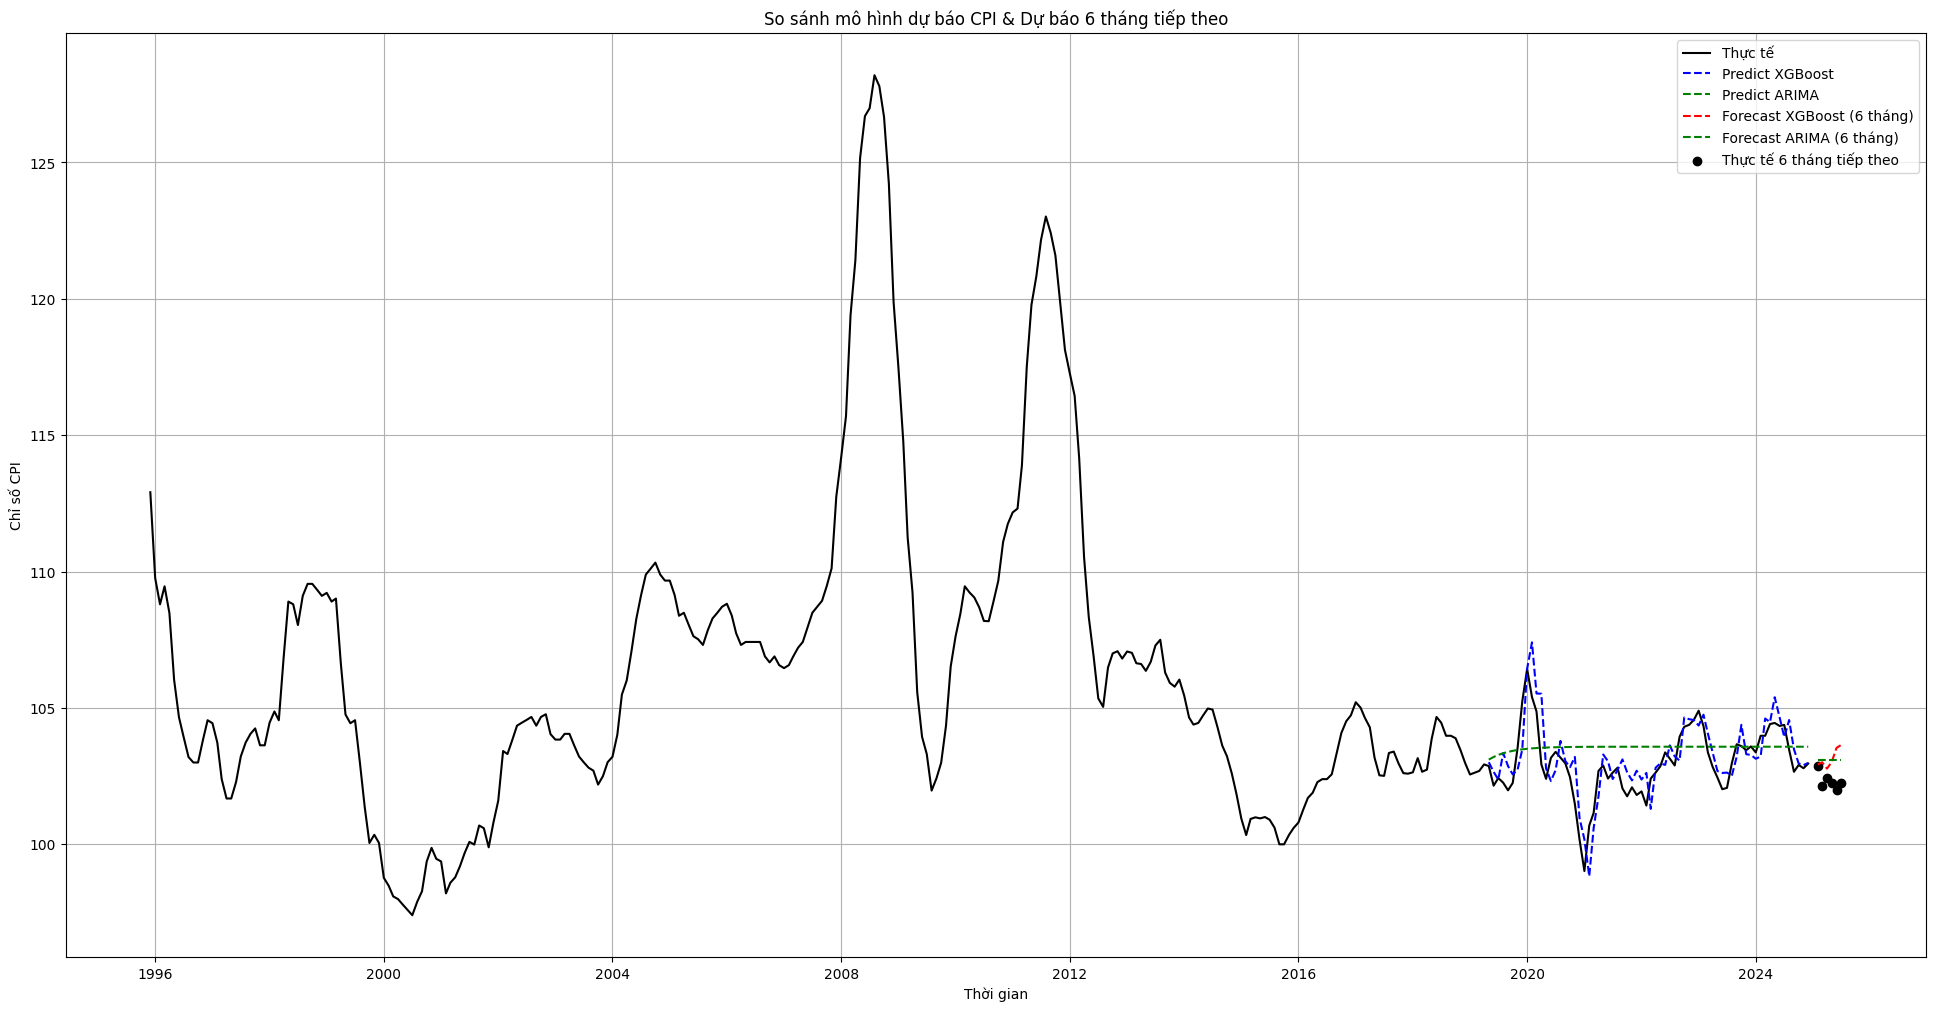

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import os

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Đảm bảo các ops của TensorFlow chạy một cách deterministically
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed()

# Chuẩn hóa dữ liệu
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df[['cpi']])

# Tạo chuỗi đầu vào cho mô hình
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 12
X, y = create_sequences(scaled_data, n_steps)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Huấn luyện mô hình XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

model_xgb = xgb.XGBRegressor(n_estimators=100)
model_xgb.fit(X_train_xgb, y_train)

# Dự báo 12 tháng với XGBoost
y_pred_xgb = model_xgb.predict(X_test_xgb)
y_pred_xgb_inv = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Huấn luyện mô hình ARIMA
train_arima = df['cpi'][:split + n_steps]
test_arima = df['cpi'][split + n_steps:]

model_arima = ARIMA(train_arima, order=(1,1,2))
model_arima_fit = model_arima.fit()
y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))

# Dự đoán thêm 6 tháng
def forecast_next_6_months(model_xgb, model_arima_fit, last_data, scaler):
    future_xgb = []
    future_arima = []

    current_xgb = last_data.reshape(1, -1)
    current_arima = df['cpi'].values

    for _ in range(6):
        # Dự đoán với XGBoost
        pred_xgb = model_xgb.predict(current_xgb)
        pred_xgb_inv = scaler.inverse_transform(pred_xgb.reshape(-1, 1))
        future_xgb.append(pred_xgb_inv[0][0])

        # Cập nhật dữ liệu cho XGBoost
        new_xgb_data = np.append(current_xgb[0, 1:], pred_xgb).reshape(1, -1)
        current_xgb = new_xgb_data

        # Dự đoán với ARIMA
        pred_arima = model_arima_fit.forecast(steps=1)[0]
        future_arima.append(pred_arima)

        # Cập nhật dữ liệu cho ARIMA
        current_arima = np.append(current_arima, pred_arima)

    return future_xgb, future_arima

# Lấy dữ liệu cuối cùng để dự đoán
last_data_xgb = X_train_xgb[-1]
future_xgb, future_arima = forecast_next_6_months(model_xgb, model_arima_fit, last_data_xgb, scaler)

# Đánh giá mô hình
def evaluate(y_true, y_pred, name):
    print(f"\n{name}")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE  : {mean_squared_error(y_true, y_pred):.4f}")
    print(f"MAPE : {mean_absolute_percentage_error(y_true, y_pred)*100:.2f}%")
    print(f"R²   : {r2_score(y_true, y_pred):.4f}")

evaluate(test_arima.values, y_pred_arima, "ARIMA")
evaluate(y_test, y_pred_xgb, "XGBoost")
# Vẽ biểu đồ so sánh kết quả
plt.figure(figsize=(24, 12))

# Vẽ dữ liệu thực tế
plt.plot(df.index, df['cpi'], label="Thực tế", color='black', linestyle='-')

# Vẽ kết quả dự đoán của XGBoost
plt.plot(df.index[split + n_steps:], y_pred_xgb_inv, label="Predict XGBoost", color='blue', linestyle='dashed')

# Vẽ kết quả dự đoán của ARIMA
plt.plot(df.index[split + n_steps:], y_pred_arima, label="Predict ARIMA", color='green', linestyle='dashed')

# Vẽ dự báo 6 tháng tiếp theo của XGBoost
forecast_dates = pd.date_range(df.index[-1], periods=7, freq='M')[1:]  # 6 tháng tiếp theo
plt.plot(forecast_dates, future_xgb, label="Forecast XGBoost (6 tháng)", color='red', linestyle='dashed')

# Vẽ dự báo 6 tháng tiếp theo của ARIMA
plt.plot(forecast_dates, future_arima, label="Forecast ARIMA (6 tháng)", color='green', linestyle='dashed')

# Vẽ dữ liệu thực tế 6 tháng tiếp theo (nếu có)
if len(df) > split + n_steps + 6:
    plt.scatter(forecast_dates, df['cpi'].iloc[split + n_steps: split + n_steps + 6], color='black', label="Thực tế 6 tháng tiếp theo")

# Thiết lập nhãn và tiêu đề
plt.xlabel("Thời gian")
plt.ylabel("Chỉ số CPI")
plt.title("So sánh mô hình dự báo CPI & Dự báo 6 tháng tiếp theo")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, LayerNormalization, Dropout, MultiHeadAttention, Flatten, RepeatVector, TimeDistributed, Lambda, Bidirectional

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def preprocess_data(data, n_steps=12, scale=True):
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data) if scale else data

    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i - n_steps:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    split = int(len(X) * 0.8)
    return X[:split], X[split:], y[:split], y[split:], scaler

def build_lstm_model(n_steps, activation='swish'):
    model = Sequential([
        LSTM(50, activation=activation, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm_model(n_steps, activation='swish'):
    model = Sequential([
        Bidirectional(LSTM(50, activation=activation, input_shape=(n_steps, 1))),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(n_steps, activation='swish'):
    model = Sequential([
        GRU(50, activation=activation, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_transformer_model(n_steps, activation='swish', d_model=32, num_heads=2, ff_dim=32, dropout_rate=0.1):
    inputs = Input(shape=(n_steps, 1))
    x = Dense(d_model, activation=activation)(inputs)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn = Dense(ff_dim, activation=activation)(out1)
    ffn = Dense(d_model)(ffn)
    ffn_output = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    flat = Flatten()(out2)
    outputs = Dense(1)(flat)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def build_seq2seq_model(n_steps, activation='swish', latent_dim=50):
    encoder_inputs = Input(shape=(n_steps, 1))
    _, state_h = GRU(latent_dim, activation=activation, return_state=True)(encoder_inputs)

    decoder_inputs = RepeatVector(1)(state_h)
    decoder_outputs = GRU(latent_dim, activation=activation, return_sequences=True)(decoder_inputs, initial_state=state_h)
    decoder_outputs = TimeDistributed(Dense(1))(decoder_outputs)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=1))(decoder_outputs)

    model = Model(encoder_inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R^2  : {r2:.4f}")

def train_and_predict(model_builder, model_name, X_train, y_train, X_test, scaler, activation):
    model = model_builder(X_train.shape[1], activation)
    model.fit(X_train, y_train, epochs=200, verbose=0)
    model.summary()
    y_pred = model.predict(X_test)
    return model, scaler.inverse_transform(y_pred) # return the trained model

def forecast_future(model, last_data, scaler, steps=6):
    predictions = []
    current_input = last_data.reshape(1, last_data.shape[0], last_data.shape[1])

    for _ in range(steps):
        pred = model.predict(current_input)
        pred_inv = scaler.inverse_transform(pred.reshape(-1, 1))
        predictions.append(pred_inv[0][0])

        new_input = np.append(current_input[0, 1:], pred).reshape(1, last_data.shape[0], last_data.shape[1])
        current_input = new_input

    return predictions

def run_pipeline(data, n_steps=12, activation='swish'):
    set_seed()
    X_train, X_test, y_train, y_test, scaler = preprocess_data(data, n_steps)
    y_test_inv = scaler.inverse_transform(y_test)

    models = {
        'LSTM': build_lstm_model,
        'BiLSTM': build_bilstm_model,
        'GRU': build_gru_model,
        'Transformer': build_transformer_model,
        'Seq2Seq': build_seq2seq_model
    }

    predictions = {}
    future_forecasts = {}

    for name, builder in models.items():
        model, y_pred = train_and_predict(builder, name, X_train, y_train, X_test, scaler, activation)  # get trained model
        predictions[name] = y_pred
        last_data = X_test[-1]
        future_forecasts[name] = forecast_future(model, last_data, scaler)  # use trained model for forecast

        evaluate(y_test_inv, y_pred, name)

    plot_results(data.index[-len(y_test):], y_test_inv, predictions, future_forecasts)

def plot_results(dates, y_true, predictions_dict, forecasts_dict):
    plt.figure(figsize=(12,6))
    plt.plot(dates, y_true, label='Thực tế', marker='o')

    future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]

    for name, y_pred in predictions_dict.items():
        plt.plot(dates, y_pred, label=f"Predict {name}", marker='x')

    for name, y_forecast in forecasts_dict.items():
        plt.plot(future_dates, y_forecast, '--', label=f"Forecast {name}")

    plt.legend()
    plt.title("So sánh các mô hình dự báo & dự báo 6 tháng tiếp theo")
    plt.xlabel("Thời gian")
    plt.ylabel("Giá trị dự báo")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

LSTM Evaluation:
MAE  : 0.4862
MSE  : 0.4249
MAPE : 0.47%
R^2  : 0.7143


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

BiLSTM Evaluation:
MAE  : 0.5164
MSE  : 0.4631
MAPE : 0.50%
R^2  : 0.6886


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_9 (GRU)                          │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

GRU Evaluation:
MAE  : 0.5064
MSE  : 0.4459
MAPE : 0.49%
R^2  : 0.7002


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 12, 32)         │             64 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 12, 32)         │          8,416 │ dense_18[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 12, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 12, 32)         │              0 │ dense_18[0][0],        │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 12, 32)         │             64 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 12, 32)         │          1,056 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 12, 32)         │          1,056 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 12, 32)         │              0 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 12, 32)         │              0 │ layer_normalization_2… │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 12, 32)         │             64 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 384)            │              0 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 1)              │            385 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Transformer Evaluation:
MAE  : 0.7263
MSE  : 0.8306
MAPE : 0.71%
R^2  : 0.4416


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_10 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_16[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 1, 50)          │              0 │ gru_10[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_11 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_2[0][0], │
│                           │                        │                │ gru_10[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 1, 1)           │             51 │ gru_11[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1)              │              0 │ time_distributed_2[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Seq2Seq Evaluation:
MAE  : 0.5232
MSE  : 0.4943
MAPE : 0.51%
R^2  : 0.6677


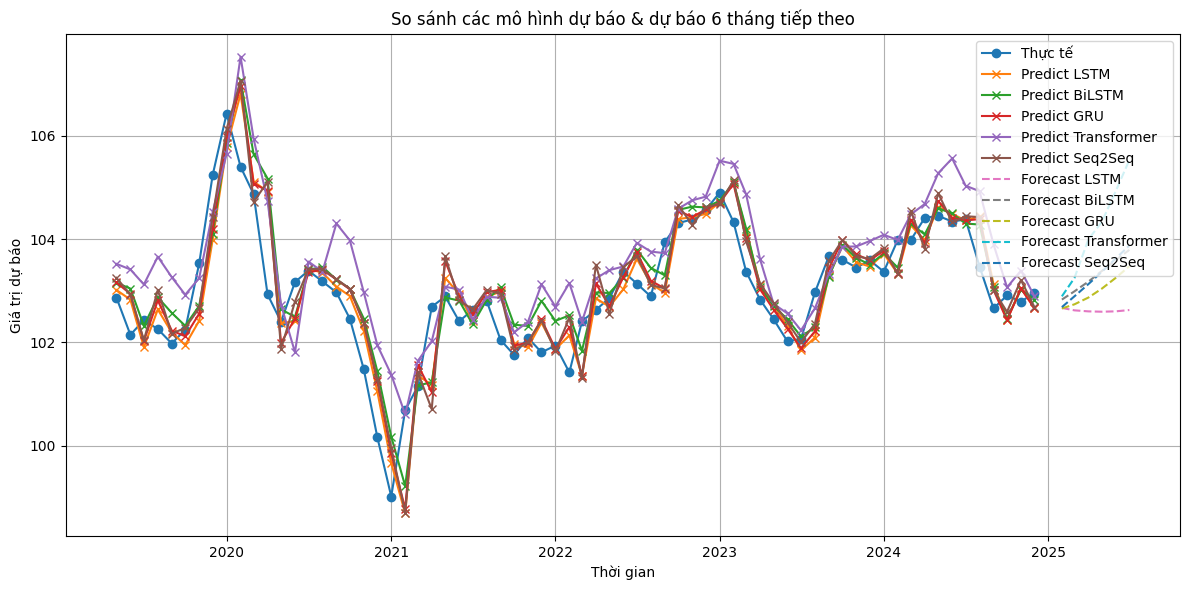

In [ ]:
run_pipeline(data, n_steps=12, activation='relu')

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

LSTM Evaluation:
MAE  : 0.5219
MSE  : 0.4318
MAPE : 0.51%
R^2  : 0.7097


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

BiLSTM Evaluation:
MAE  : 0.5042
MSE  : 0.4253
MAPE : 0.49%
R^2  : 0.7141


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

GRU Evaluation:
MAE  : 0.5008
MSE  : 0.4362
MAPE : 0.49%
R^2  : 0.7068


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 12, 32)         │             64 │ input_layer_20[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 12, 32)         │          8,416 │ dense_26[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 12, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 12, 32)         │              0 │ dense_26[0][0],        │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 12, 32)         │             64 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 12, 32)         │          1,056 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 12, 32)         │          1,056 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 12, 32)         │              0 │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 12, 32)         │              0 │ layer_normalization_4… │
│                           │                        │                │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 12, 32)         │             64 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 384)            │              0 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 1)              │            385 │ flatten_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Transformer Evaluation:
MAE  : 0.5032
MSE  : 0.4522
MAPE : 0.49%
R^2  : 0.6960


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_13 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_21[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_3           │ (None, 1, 50)          │              0 │ gru_13[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_14 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_3[0][0], │
│                           │                        │                │ gru_13[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 1, 1)           │             51 │ gru_14[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1)              │              0 │ time_distributed_3[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Seq2Seq Evaluation:
MAE  : 0.4932
MSE  : 0.4302
MAPE : 0.48%
R^2  : 0.7108


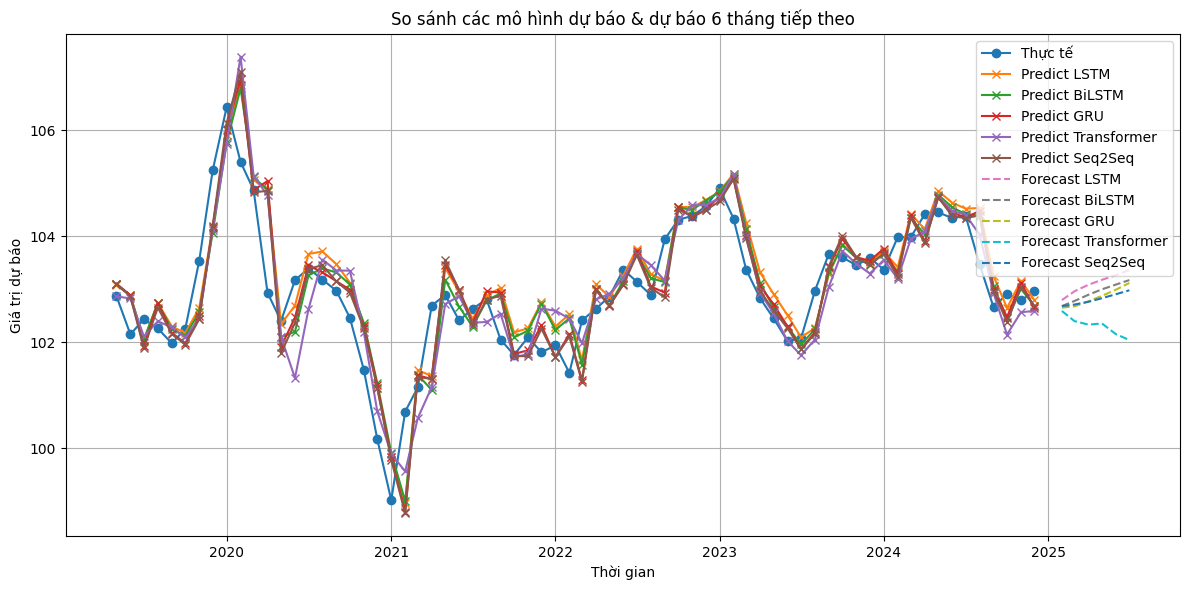

In [ ]:
run_pipeline(data, n_steps=12, activation='tanh')

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

LSTM Evaluation:
MAE  : 0.4963
MSE  : 0.4085
MAPE : 0.48%
R^2  : 0.7253


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

BiLSTM Evaluation:
MAE  : 0.5198
MSE  : 0.4297
MAPE : 0.51%
R^2  : 0.7111


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_15 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

GRU Evaluation:
MAE  : 0.4985
MSE  : 0.4328
MAPE : 0.48%
R^2  : 0.7090


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 12, 32)         │             64 │ input_layer_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 12, 32)         │          8,416 │ dense_34[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 12, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 12, 32)         │              0 │ dense_34[0][0],        │
│                           │                        │                │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 12, 32)         │             64 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 12, 32)         │          1,056 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 12, 32)         │          1,056 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 12, 32)         │              0 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 12, 32)         │              0 │ layer_normalization_6… │
│                           │                        │                │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 12, 32)         │             64 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 384)            │              0 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 1)              │            385 │ flatten_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Transformer Evaluation:
MAE  : 0.5318
MSE  : 0.4724
MAPE : 0.52%
R^2  : 0.6824


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_16 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_26[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_4           │ (None, 1, 50)          │              0 │ gru_16[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_17 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_4[0][0], │
│                           │                        │                │ gru_16[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 1, 1)           │             51 │ gru_17[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 1)              │              0 │ time_distributed_4[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Seq2Seq Evaluation:
MAE  : 0.4982
MSE  : 0.4271
MAPE : 0.48%
R^2  : 0.7128


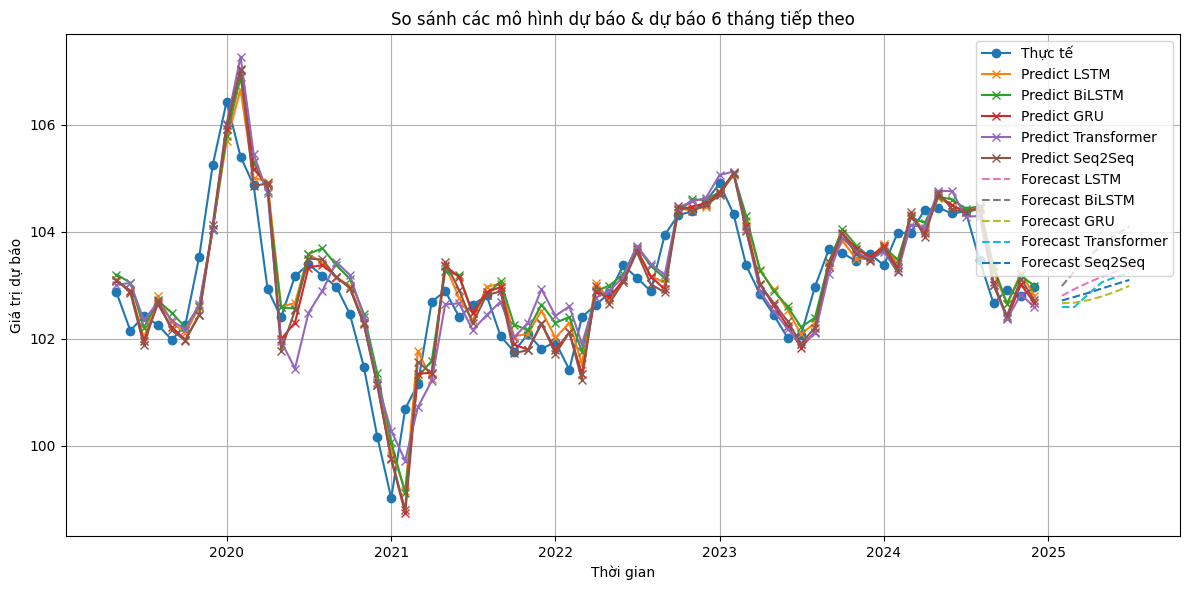

In [ ]:
run_pipeline(data, n_steps=12, activation='swish')

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

LSTM Evaluation:
MAE  : 0.5236
MSE  : 0.4663
MAPE : 0.51%
R^2  : 0.6970


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

BiLSTM Evaluation:
MAE  : 0.5490
MSE  : 0.5047
MAPE : 0.53%
R^2  : 0.6720


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

GRU Evaluation:
MAE  : 0.5100
MSE  : 0.4634
MAPE : 0.50%
R^2  : 0.6988


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30            │ (None, 24, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 24, 32)         │             64 │ input_layer_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 24, 32)         │          8,416 │ dense_42[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 24, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 24, 32)         │              0 │ dense_42[0][0],        │
│                           │                        │                │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 24, 32)         │             64 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 24, 32)         │          1,056 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 24, 32)         │          1,056 │ dense_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 24, 32)         │              0 │ dense_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 24, 32)         │              0 │ layer_normalization_8… │
│                           │                        │                │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 24, 32)         │             64 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 768)            │              0 │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 1)              │            769 │ flatten_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,469 (134.65 KB)

 Trainable params: 11,489 (44.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,980 (89.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Transformer Evaluation:
MAE  : 0.7291
MSE  : 0.7781
MAPE : 0.71%
R^2  : 0.4943


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31            │ (None, 24, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_19 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_31[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_5           │ (None, 1, 50)          │              0 │ gru_19[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_20 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_5[0][0], │
│                           │                        │                │ gru_19[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, 1, 1)           │             51 │ gru_20[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 1)              │              0 │ time_distributed_5[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Seq2Seq Evaluation:
MAE  : 0.4990
MSE  : 0.4492
MAPE : 0.49%
R^2  : 0.7081


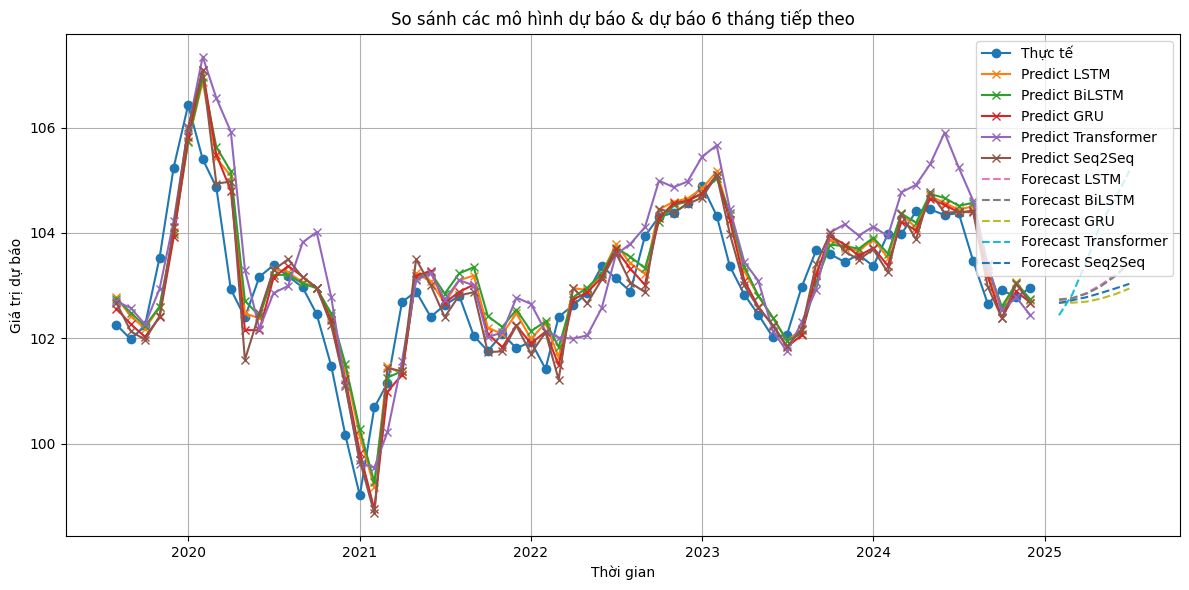

In [ ]:
run_pipeline(data, n_steps=24, activation='swish')

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

LSTM Evaluation:
MAE  : 0.5025
MSE  : 0.4148
MAPE : 0.49%
R^2  : 0.7170


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

BiLSTM Evaluation:
MAE  : 0.5440
MSE  : 0.4862
MAPE : 0.53%
R^2  : 0.6683


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_21 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

GRU Evaluation:
MAE  : 0.4908
MSE  : 0.4164
MAPE : 0.48%
R^2  : 0.7160


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35            │ (None, 6, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 6, 32)          │             64 │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 6, 32)          │          8,416 │ dense_50[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 6, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 6, 32)          │              0 │ dense_50[0][0],        │
│                           │                        │                │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 6, 32)          │             64 │ add_10[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 6, 32)          │          1,056 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 6, 32)          │          1,056 │ dense_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 6, 32)          │              0 │ dense_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 6, 32)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_11    │ (None, 6, 32)          │             64 │ add_11[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 192)            │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 1)              │            193 │ flatten_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,741 (127.90 KB)

 Trainable params: 10,913 (42.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,828 (85.27 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Transformer Evaluation:
MAE  : 0.7368
MSE  : 0.7574
MAPE : 0.72%
R^2  : 0.4833


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36            │ (None, 6, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_22 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_36[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_6           │ (None, 1, 50)          │              0 │ gru_22[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_23 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_6[0][0], │
│                           │                        │                │ gru_22[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_6        │ (None, 1, 1)           │             51 │ gru_23[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 1)              │              0 │ time_distributed_6[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Seq2Seq Evaluation:
MAE  : 0.4889
MSE  : 0.4112
MAPE : 0.48%
R^2  : 0.7195


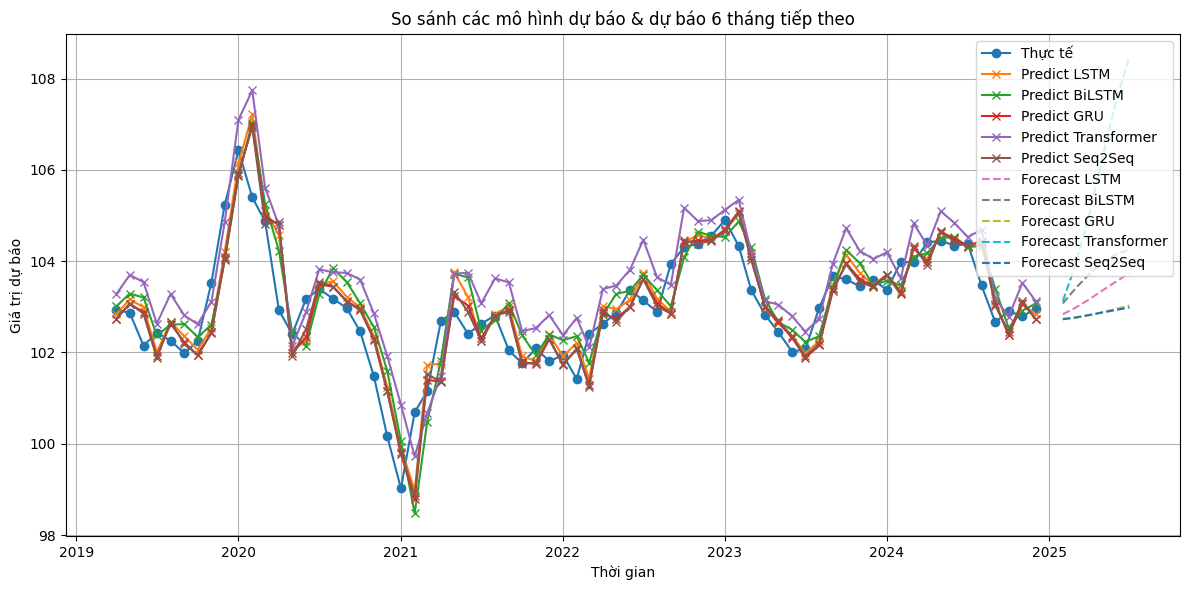

In [ ]:
run_pipeline(data, n_steps=6, activation='swish')

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

LSTM Evaluation:
MAE  : 0.4973
MSE  : 0.4287
MAPE : 0.48%
R^2  : 0.7036


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

BiLSTM Evaluation:
MAE  : 0.5520
MSE  : 0.5392
MAPE : 0.54%
R^2  : 0.6272


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_24 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

GRU Evaluation:
MAE  : 0.4928
MSE  : 0.4262
MAPE : 0.48%
R^2  : 0.7053


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 3, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_58 (Dense)          │ (None, 3, 32)          │             64 │ input_layer_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_6    │ (None, 3, 32)          │          8,416 │ dense_58[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_58[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 3, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 3, 32)          │              0 │ dense_58[0][0],        │
│                           │                        │                │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 3, 32)          │             64 │ add_12[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_59 (Dense)          │ (None, 3, 32)          │          1,056 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 3, 32)          │          1,056 │ dense_59[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 3, 32)          │              0 │ dense_60[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 3, 32)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 3, 32)          │             64 │ add_13[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 96)             │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_61 (Dense)          │ (None, 1)              │             97 │ flatten_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,453 (126.77 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,636 (84.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Transformer Evaluation:
MAE  : 0.4920
MSE  : 0.4324
MAPE : 0.48%
R^2  : 0.7011


Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41            │ (None, 3, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_25 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_41[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_7           │ (None, 1, 50)          │              0 │ gru_25[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_26 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_7[0][0], │
│                           │                        │                │ gru_25[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_7        │ (None, 1, 1)           │             51 │ gru_26[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 1)              │              0 │ time_distributed_7[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Seq2Seq Evaluation:
MAE  : 0.4840
MSE  : 0.4138
MAPE : 0.47%
R^2  : 0.7139


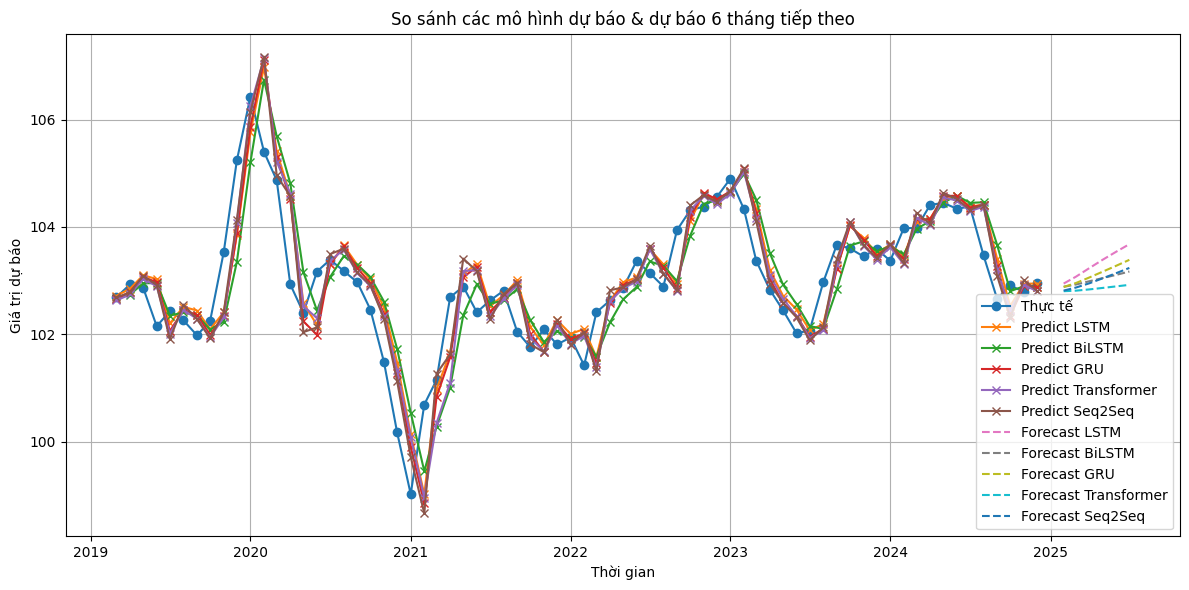

In [ ]:
run_pipeline(data, n_steps=3, activation='swish')

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

LSTM Evaluation:
MAE  : 0.5125
MSE  : 0.4659
MAPE : 0.50%
R^2  : 0.6779


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

BiLSTM Evaluation:
MAE  : 0.5136
MSE  : 0.4674
MAPE : 0.50%
R^2  : 0.6768


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_27 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

GRU Evaluation:
MAE  : 0.4746
MSE  : 0.4021
MAPE : 0.46%
R^2  : 0.7220


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45            │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_66 (Dense)          │ (None, 2, 32)          │             64 │ input_layer_45[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 2, 32)          │          8,416 │ dense_66[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_66[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 2, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 2, 32)          │              0 │ dense_66[0][0],        │
│                           │                        │                │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 2, 32)          │             64 │ add_14[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_67 (Dense)          │ (None, 2, 32)          │          1,056 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_68 (Dense)          │ (None, 2, 32)          │          1,056 │ dense_67[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 2, 32)          │              0 │ dense_68[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 2, 32)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 2, 32)          │             64 │ add_15[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 64)             │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_69 (Dense)          │ (None, 1)              │             65 │ flatten_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,357 (126.40 KB)

 Trainable params: 10,785 (42.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,572 (84.27 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Transformer Evaluation:
MAE  : 0.4999
MSE  : 0.4245
MAPE : 0.49%
R^2  : 0.7065


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46            │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_28 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_46[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_8           │ (None, 1, 50)          │              0 │ gru_28[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_29 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_8[0][0], │
│                           │                        │                │ gru_28[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_8        │ (None, 1, 1)           │             51 │ gru_29[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_8 (Lambda)         │ (None, 1)              │              0 │ time_distributed_8[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Seq2Seq Evaluation:
MAE  : 0.4848
MSE  : 0.4074
MAPE : 0.47%
R^2  : 0.7183


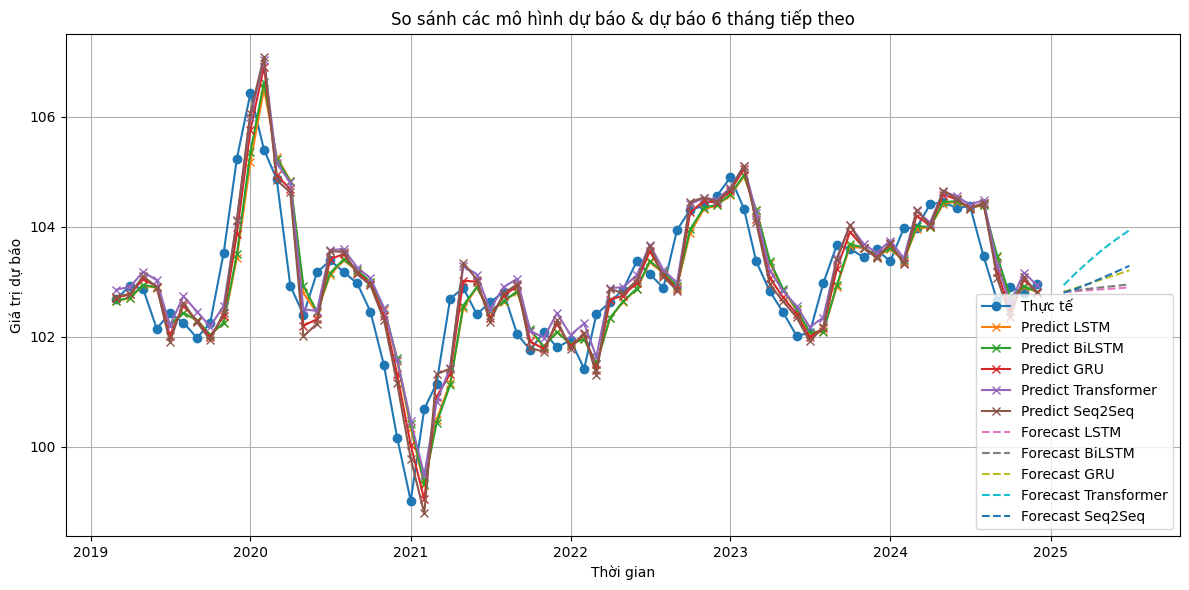

In [ ]:
run_pipeline(data, n_steps=2, activation='swish')

#### Dung mo hinh du doan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, LayerNormalization, Dropout, MultiHeadAttention, Flatten, RepeatVector, TimeDistributed, Lambda, Bidirectional
import random
import os

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def preprocess_data(data, n_steps=12, scale=True):
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data) if scale else data

    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i - n_steps:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    split = int(len(X) * 0.8)
    return X[:split], X[split:], y[:split], y[split:], scaler

def build_lstm_model(n_steps, activation='swish'):
    model = Sequential([
        LSTM(50, activation=activation, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm_model(n_steps, activation='swish'):
    model = Sequential([
        Bidirectional(LSTM(50, activation=activation, input_shape=(n_steps, 1))),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(n_steps, activation='swish'):
    model = Sequential([
        GRU(50, activation=activation, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_transformer_model(n_steps, activation='swish', d_model=32, num_heads=2, ff_dim=32, dropout_rate=0.1):
    inputs = Input(shape=(n_steps, 1))
    x = Dense(d_model, activation=activation)(inputs)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn = Dense(ff_dim, activation=activation)(out1)
    ffn = Dense(d_model)(ffn)
    ffn_output = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    flat = Flatten()(out2)
    outputs = Dense(1)(flat)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def build_seq2seq_model(n_steps, activation='swish', latent_dim=50):
    encoder_inputs = Input(shape=(n_steps, 1))
    _, state_h = GRU(latent_dim, activation=activation, return_state=True)(encoder_inputs)

    decoder_inputs = RepeatVector(1)(state_h)
    decoder_outputs = GRU(latent_dim, activation=activation, return_sequences=True)(decoder_inputs, initial_state=state_h)
    decoder_outputs = TimeDistributed(Dense(1))(decoder_outputs)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=1))(decoder_outputs)

    model = Model(encoder_inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R^2  : {r2:.4f}")

def train_and_predict(model_builder, model_name, X_train, y_train, X_test, scaler, activation):
    model = model_builder(X_train.shape[1], activation)
    model.fit(X_train, y_train, epochs=200, verbose=0)
    model.summary()
    y_pred = model.predict(X_test)
    return model, scaler.inverse_transform(y_pred) # return the trained model

def forecast_future(model, last_data, scaler, steps=6):
    predictions = []
    current_input = last_data.reshape(1, last_data.shape[0], last_data.shape[1])

    for _ in range(steps):
        pred = model.predict(current_input)
        pred_inv = scaler.inverse_transform(pred.reshape(-1, 1))
        predictions.append(pred_inv[0][0])

        new_input = np.append(current_input[0, 1:], pred).reshape(1, last_data.shape[0], last_data.shape[1])
        current_input = new_input

    return predictions

def run_pipeline(data, n_steps=12, activation='swish'):
    set_seed()
    X_train, X_test, y_train, y_test, scaler = preprocess_data(data, n_steps)
    y_test_inv = scaler.inverse_transform(y_test)

    models = {
        'LSTM': build_lstm_model,
        'GRU': build_gru_model,
        'Seq2Seq': build_seq2seq_model
    }

    predictions = {}
    future_forecasts = {}

    for name, builder in models.items():
        model, y_pred = train_and_predict(builder, name, X_train, y_train, X_test, scaler, activation)  # get trained model
        predictions[name] = y_pred
        last_data = X_test[-1]
        future_forecasts[name] = forecast_future(model, last_data, scaler)  # use trained model for forecast

        evaluate(y_test_inv, y_pred, name)

    print(future_forecasts)
    plot_results(data.index[-len(y_test):], y_test_inv, predictions, future_forecasts)

def plot_results(dates, y_true, predictions_dict, forecasts_dict):
    plt.figure(figsize=(12,6))
    plt.plot(dates, y_true, label='Thực tế', marker='o')

    future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]

    for name, y_pred in predictions_dict.items():
        plt.plot(dates, y_pred, label=f"Predict {name}", marker='x')

    for name, y_forecast in forecasts_dict.items():
        plt.plot(future_dates, y_forecast, '--', label=f"Forecast {name}")

    plt.legend()
    plt.title("So sánh các mô hình dự báo & dự báo 6 tháng tiếp theo")
    plt.xlabel("Thời gian")
    plt.ylabel("Giá trị dự báo")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

LSTM Evaluation:
MAE  : 0.4963
MSE  : 0.4085
MAPE : 0.48%
R^2  : 0.7253


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

GRU Evaluation:
MAE  : 0.5123
MSE  : 0.4433
MAPE : 0.50%
R^2  : 0.7020


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ [(None, 50), (None,    │          7,950 │ input_layer_2[0][0]    │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 1, 50)          │              0 │ gru_1[0][1]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ (None, 1, 50)          │         15,300 │ repeat_vector[0][0],   │
│                           │                        │                │ gru_1[0][1]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 1, 1)           │             51 │ gru_2[0][0]            │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ time_distributed[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Seq2Seq Evaluation:
MAE  : 0.5005
MSE  : 0.4437
MAPE : 0.49%
R^2  : 0.7017
{'LSTM': [np.float32(102.80426), np.float32(102.928276), np.float32(103.05251), np.float32(103.156784), np.float32(103.25491), np.float32(103.3633)], 'GRU': [np.float32(102.69812), np.float32(102.75875), np.float32(102.84408), np.float32(102.93709), np.float32(103.04726), np.float32(103.17611)], 'Seq2Seq': [np.float32(102.62838), np.float32(102.613075), np.float32(102.61911), np.float32(102.6418), np.float32(102.675354), np.float32(102.714676)]}


<ipython-input-9-29cdcb2c91dd>:150: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]


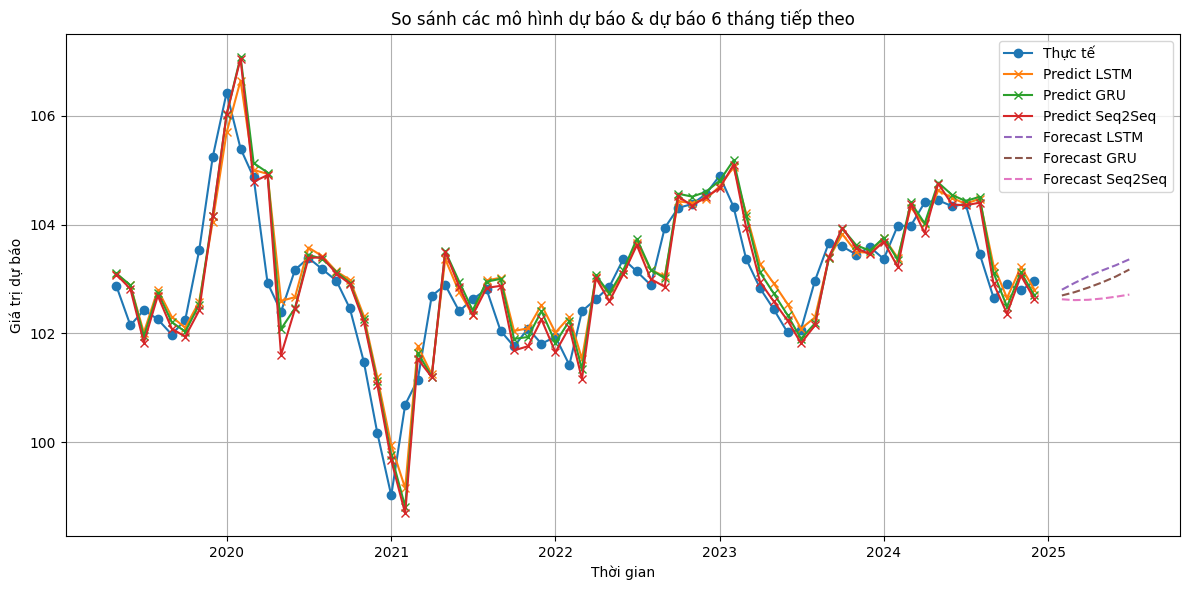

In [ ]:
n_steps=12
run_pipeline(data, n_steps, "swish")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

LSTM Evaluation:
MAE  : 0.4747
MSE  : 0.4088
MAPE : 0.46%
R^2  : 0.7173


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                          │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

GRU Evaluation:
MAE  : 0.4746
MSE  : 0.4030
MAPE : 0.46%
R^2  : 0.7214


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_7 (GRU)               │ [(None, 50), (None,    │          7,950 │ input_layer_8[0][0]    │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 1, 50)          │              0 │ gru_7[0][1]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_8 (GRU)               │ (None, 1, 50)          │         15,300 │ repeat_vector_2[0][0], │
│                           │                        │                │ gru_7[0][1]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 1, 1)           │             51 │ gru_8[0][0]            │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1)              │              0 │ time_distributed_2[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Seq2Seq Evaluation:
MAE  : 0.4770
MSE  : 0.4024
MAPE : 0.46%
R^2  : 0.7218
{'LSTM': [np.float32(102.786736), np.float32(102.80463), np.float32(102.825745), np.float32(102.84691), np.float32(102.86758), np.float32(102.887665)], 'GRU': [np.float32(102.81387), np.float32(102.87846), np.float32(102.953354), np.float32(103.03015), np.float32(103.106575), np.float32(103.18201)], 'Seq2Seq': [np.float32(102.76782), np.float32(102.78575), np.float32(102.81956), np.float32(102.859344), np.float32(102.90108), np.float32(102.94316)]}


<ipython-input-9-29cdcb2c91dd>:150: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]


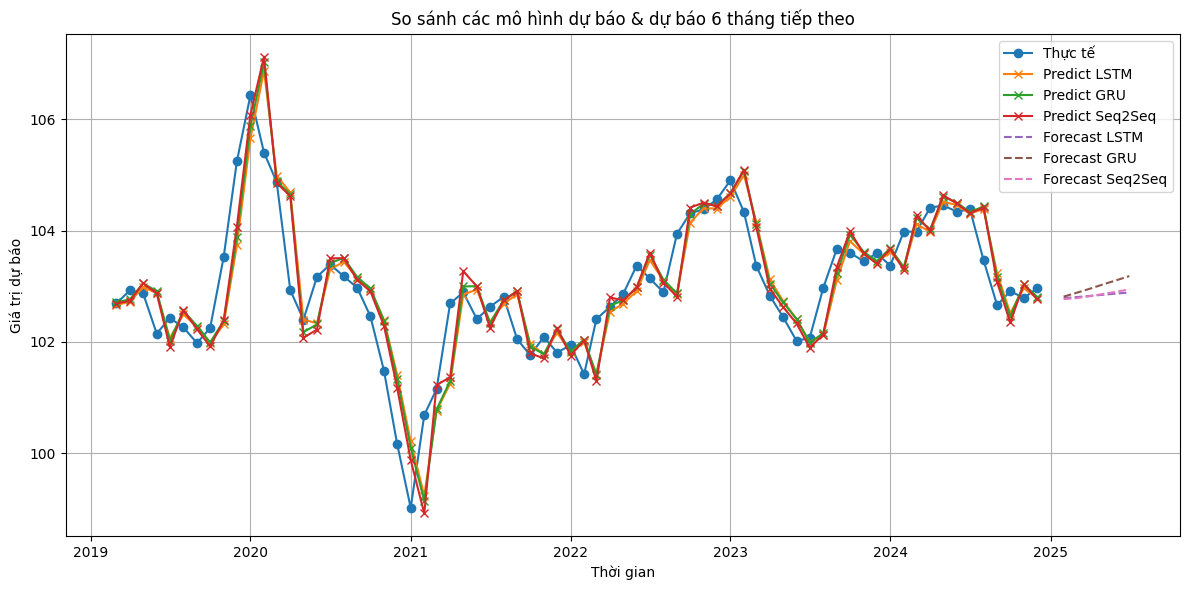

In [ ]:
n_steps=2
run_pipeline(data, n_steps, "tanh")

## 4. Thu nghiem mo hinh tren CPI MoM

#### Input với các step

In [ ]:
path = "/content/drive/MyDrive/University/Năm 3_HK2/Phương pháp nghiên cứu khoa học /cpi/cpi_processed.csv"

data = pd.read_csv(path)
data['date'] = pd.to_datetime(data['time'])
data.drop('time', axis=1, inplace=True)
data.drop('cpi_yoy', axis=1, inplace=True)
data['cpi'] = data['cpi_mom'].astype(float)
data.drop('cpi_mom', axis=1, inplace=True)
data.set_index('date', inplace=True)
data.head()
data.to_csv('/content/drive/MyDrive/University/Năm 3_HK2/Phương pháp nghiên cứu khoa học /cpi/cpi_mom.csv')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb

df = data.copy()
# Chuẩn hóa dữ liệu
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)

# Tạo chuỗi đầu vào cho LSTM & XGBoost
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [ ]:
n_steps = 12
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to be 2-dimensional
X_2d = X.reshape(X.shape[0], -1)

# Now create the DataFrame, use y.flatten() to ensure a 1D index
dt = pd.DataFrame(X_2d, index=y.flatten())  # using y as index
dt

0         1         2         3         4         5   \
 0.958904  0.000000  0.821918  3.013699  0.684932 -0.273973 -1.095890   
 0.684932  0.821918  3.013699  0.684932 -0.273973 -1.095890 -1.095890   
 2.054795  3.013699  0.684932 -0.273973 -1.095890 -1.095890 -1.369863   
-1.095890  0.684932 -0.273973 -1.095890 -1.095890 -1.369863 -0.958904   
-1.232877 -0.273973 -1.095890 -1.095890 -1.369863 -0.958904  0.000000   
...             ...       ...       ...       ...       ...       ...   
-0.410959  0.794521  1.068493 -0.301370 -0.068493 -0.246575  0.013699   
-0.013699  1.068493 -0.301370 -0.068493 -0.246575  0.013699  1.013699   
 0.041096 -0.301370 -0.068493 -0.246575  0.013699  1.013699 -0.726027   
-0.232877 -0.068493 -0.246575  0.013699  1.013699 -0.726027 -0.315068   
-0.013699 -0.246575  0.013699  1.013699 -0.726027 -0.315068 -0.342466   

                 6         7         8         9         10        11  
 0.958904 -1.095890 -1.369863 -0.958904  0.000000 -0.273973  0.821918  
 0.684932 -1.369863 -0.958904  0.000000 -0.273973  0.821918  0.958904  
 2.054795 -0.958904  0.000000 -0.273973  0.821918  0.958904  0.684932  
-1.095890  0.000000 -0.273973  0.821918  0.958904  0.684932  2.054795  
-1.232877 -0.273973  0.821918  0.958904  0.684932  2.054795 -1.095890  
...             ...       ...       ...       ...       ...       ...  
-0.410959  1.013699 -0.726027 -0.315068 -0.342466 -0.178082  0.246575  
-0.013699 -0.726027 -0.315068 -0.342466 -0.178082  0.246575 -0.410959  
 0.041096 -0.315068 -0.342466 -0.178082  0.246575 -0.410959 -0.013699  
-0.232877 -0.342466 -0.178082  0.246575 -0.410959 -0.013699  0.041096  
-0.013699 -0.178082  0.246575 -0.410959 -0.013699  0.041096 -0.232877  

[337 rows x 12 columns]

In [ ]:
n_steps = 6
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to be 2-dimensional
X_2d = X.reshape(X.shape[0], -1)

# Now create the DataFrame, use y.flatten() to ensure a 1D index
dt = pd.DataFrame(X_2d, index=y.flatten())  # using y as index
dt

0         1         2         3         4         5
-1.095890  0.000000  0.821918  3.013699  0.684932 -0.273973 -1.095890
-1.369863  0.821918  3.013699  0.684932 -0.273973 -1.095890 -1.095890
-0.958904  3.013699  0.684932 -0.273973 -1.095890 -1.095890 -1.369863
 0.000000  0.684932 -0.273973 -1.095890 -1.095890 -1.369863 -0.958904
-0.273973 -0.273973 -1.095890 -1.095890 -1.369863 -0.958904  0.000000
...             ...       ...       ...       ...       ...       ...
-0.410959  1.013699 -0.726027 -0.315068 -0.342466 -0.178082  0.246575
-0.013699 -0.726027 -0.315068 -0.342466 -0.178082  0.246575 -0.410959
 0.041096 -0.315068 -0.342466 -0.178082  0.246575 -0.410959 -0.013699
-0.232877 -0.342466 -0.178082  0.246575 -0.410959 -0.013699  0.041096
-0.013699 -0.178082  0.246575 -0.410959 -0.013699  0.041096 -0.232877

[343 rows x 6 columns]

In [ ]:
n_steps = 3
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to be 2-dimensional
X_2d = X.reshape(X.shape[0], -1)

# Now create the DataFrame, use y.flatten() to ensure a 1D index
dt = pd.DataFrame(X_2d, index=y.flatten())  # using y as index
dt

0         1         2
 0.684932  0.000000  0.821918  3.013699
-0.273973  0.821918  3.013699  0.684932
-1.095890  3.013699  0.684932 -0.273973
-1.095890  0.684932 -0.273973 -1.095890
-1.369863 -0.273973 -1.095890 -1.095890
...             ...       ...       ...
-0.410959 -0.342466 -0.178082  0.246575
-0.013699 -0.178082  0.246575 -0.410959
 0.041096  0.246575 -0.410959 -0.013699
-0.232877 -0.410959 -0.013699  0.041096
-0.013699 -0.013699  0.041096 -0.232877

[346 rows x 3 columns]

In [ ]:
n_steps = 2
X, y = create_sequences(scaled_data, n_steps)

# Reshape X to be 2-dimensional
X_2d = X.reshape(X.shape[0], -1)

# Now create the DataFrame, use y.flatten() to ensure a 1D index
dt = pd.DataFrame(X_2d, index=y.flatten())  # using y as index
dt

0         1
 3.013699  0.000000  0.821918
 0.684932  0.821918  3.013699
-0.273973  3.013699  0.684932
-1.095890  0.684932 -0.273973
-1.095890 -0.273973 -1.095890
...             ...       ...
-0.410959 -0.178082  0.246575
-0.013699  0.246575 -0.410959
 0.041096 -0.410959 -0.013699
-0.232877 -0.013699  0.041096
-0.013699  0.041096 -0.232877

[347 rows x 2 columns]

#### Thử nghiệm mô hình


ARIMA
MAE  : 0.3387
MSE  : 0.2271
MAPE : 0.34%
R²   : -0.0075

XGBoost
MAE  : 0.5614
MSE  : 0.5244
MAPE : 280.22%
R²   : -0.2397


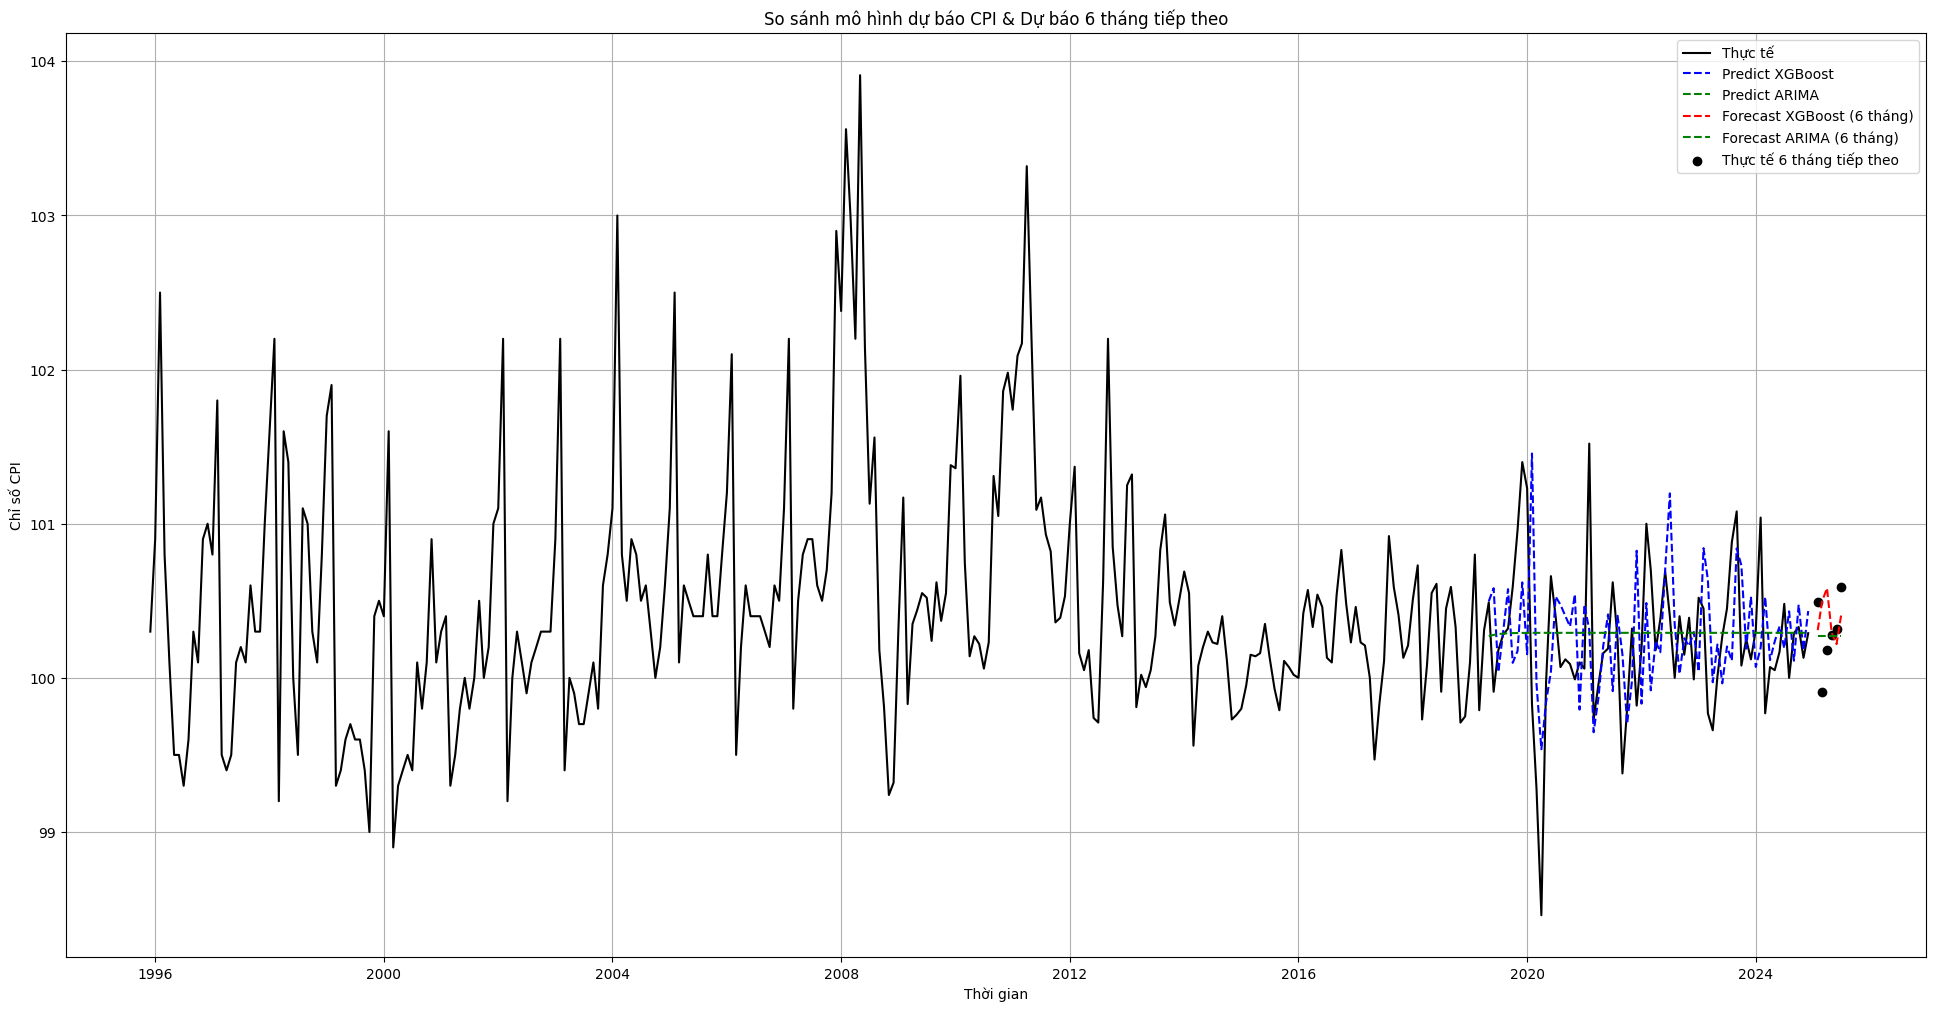

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

# Giả sử df là DataFrame chứa dữ liệu CPI với cột 'cpi' và chỉ số thời gian
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Đảm bảo các ops của TensorFlow chạy một cách deterministically
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed()
# Chuẩn hóa dữ liệu
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df[['cpi']])

# Tạo chuỗi đầu vào cho mô hình
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 12
X, y = create_sequences(scaled_data, n_steps)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Huấn luyện mô hình XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

model_xgb = xgb.XGBRegressor(n_estimators=100)
model_xgb.fit(X_train_xgb, y_train)

# Dự báo 12 tháng với XGBoost
y_pred_xgb = model_xgb.predict(X_test_xgb)
y_pred_xgb_inv = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Huấn luyện mô hình ARIMA
train_arima = df['cpi'][:split + n_steps]
test_arima = df['cpi'][split + n_steps:]

model_arima = ARIMA(train_arima, order=(1,1,2))
model_arima_fit = model_arima.fit()
y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))

# Dự đoán thêm 6 tháng
def forecast_next_6_months(model_xgb, model_arima_fit, last_data, scaler):
    future_xgb = []
    future_arima = []

    current_xgb = last_data.reshape(1, -1)
    current_arima = df['cpi'].values

    for _ in range(6):
        # Dự đoán với XGBoost
        pred_xgb = model_xgb.predict(current_xgb)
        pred_xgb_inv = scaler.inverse_transform(pred_xgb.reshape(-1, 1))
        future_xgb.append(pred_xgb_inv[0][0])

        # Cập nhật dữ liệu cho XGBoost
        new_xgb_data = np.append(current_xgb[0, 1:], pred_xgb).reshape(1, -1)
        current_xgb = new_xgb_data

        # Dự đoán với ARIMA
        pred_arima = model_arima_fit.forecast(steps=1)[0]
        future_arima.append(pred_arima)

        # Cập nhật dữ liệu cho ARIMA
        current_arima = np.append(current_arima, pred_arima)

    return future_xgb, future_arima

# Lấy dữ liệu cuối cùng để dự đoán
last_data_xgb = X_train_xgb[-1]
future_xgb, future_arima = forecast_next_6_months(model_xgb, model_arima_fit, last_data_xgb, scaler)

# Đánh giá mô hình
def evaluate(y_true, y_pred, name):
    print(f"\n{name}")
    print(f"MAE  : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE  : {mean_squared_error(y_true, y_pred):.4f}")
    print(f"MAPE : {mean_absolute_percentage_error(y_true, y_pred)*100:.2f}%")
    print(f"R²   : {r2_score(y_true, y_pred):.4f}")

evaluate(test_arima.values, y_pred_arima, "ARIMA")
evaluate(y_test, y_pred_xgb, "XGBoost")
# Vẽ biểu đồ so sánh kết quả
plt.figure(figsize=(24, 12))

# Vẽ dữ liệu thực tế
plt.plot(df.index, df['cpi'], label="Thực tế", color='black', linestyle='-')

# Vẽ kết quả dự đoán của XGBoost
plt.plot(df.index[split + n_steps:], y_pred_xgb_inv, label="Predict XGBoost", color='blue', linestyle='dashed')

# Vẽ kết quả dự đoán của ARIMA
plt.plot(df.index[split + n_steps:], y_pred_arima, label="Predict ARIMA", color='green', linestyle='dashed')

# Vẽ dự báo 6 tháng tiếp theo của XGBoost
forecast_dates = pd.date_range(df.index[-1], periods=7, freq='M')[1:]  # 6 tháng tiếp theo
plt.plot(forecast_dates, future_xgb, label="Forecast XGBoost (6 tháng)", color='red', linestyle='dashed')

# Vẽ dự báo 6 tháng tiếp theo của ARIMA
plt.plot(forecast_dates, future_arima, label="Forecast ARIMA (6 tháng)", color='green', linestyle='dashed')

# Vẽ dữ liệu thực tế 6 tháng tiếp theo (nếu có)
if len(df) > split + n_steps + 6:
    plt.scatter(forecast_dates, df['cpi'].iloc[split + n_steps: split + n_steps + 6], color='black', label="Thực tế 6 tháng tiếp theo")

# Thiết lập nhãn và tiêu đề
plt.xlabel("Thời gian")
plt.ylabel("Chỉ số CPI")
plt.title("So sánh mô hình dự báo CPI & Dự báo 6 tháng tiếp theo")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, LayerNormalization, Dropout, MultiHeadAttention, Flatten, RepeatVector, TimeDistributed, Lambda, Bidirectional

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Đảm bảo các ops của TensorFlow chạy một cách deterministically
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def preprocess_data(data, n_steps=12, scale=True):
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data) if scale else data

    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i - n_steps:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    split = int(len(X) * 0.8)
    return X[:split], X[split:], y[:split], y[split:], scaler

def build_lstm_model(n_steps, activation='swish'):
    model = Sequential([
        LSTM(50, activation=activation, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm_model(n_steps, activation='swish'):
    model = Sequential([
        Bidirectional(LSTM(50, activation=activation, input_shape=(n_steps, 1))),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(n_steps, activation='swish'):
    model = Sequential([
        GRU(50, activation=activation, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_transformer_model(n_steps, activation='swish', d_model=32, num_heads=2, ff_dim=32, dropout_rate=0.1):
    inputs = Input(shape=(n_steps, 1))
    x = Dense(d_model, activation=activation)(inputs)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn = Dense(ff_dim, activation=activation)(out1)
    ffn = Dense(d_model)(ffn)
    ffn_output = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    flat = Flatten()(out2)
    outputs = Dense(1)(flat)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def build_seq2seq_model(n_steps, activation='swish', latent_dim=50):
    encoder_inputs = Input(shape=(n_steps, 1))
    _, state_h = GRU(latent_dim, activation=activation, return_state=True)(encoder_inputs)

    decoder_inputs = RepeatVector(1)(state_h)
    decoder_outputs = GRU(latent_dim, activation=activation, return_sequences=True)(decoder_inputs, initial_state=state_h)
    decoder_outputs = TimeDistributed(Dense(1))(decoder_outputs)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=1))(decoder_outputs)

    model = Model(encoder_inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R^2  : {r2:.4f}")

def train_and_predict(model_builder, model_name, X_train, y_train, X_test, scaler, activation):
    model = model_builder(X_train.shape[1], activation)
    model.fit(X_train, y_train, epochs=200, verbose=0)
    model.summary()
    y_pred = model.predict(X_test)
    return model, scaler.inverse_transform(y_pred) # return the trained model

def forecast_future(model, last_data, scaler, steps=6):
    predictions = []
    current_input = last_data.reshape(1, last_data.shape[0], last_data.shape[1])

    for _ in range(steps):
        pred = model.predict(current_input)
        pred_inv = scaler.inverse_transform(pred.reshape(-1, 1))
        predictions.append(pred_inv[0][0])

        new_input = np.append(current_input[0, 1:], pred).reshape(1, last_data.shape[0], last_data.shape[1])
        current_input = new_input

    return predictions

def run_pipeline(data, n_steps=12, activation='swish'):
    X_train, X_test, y_train, y_test, scaler = preprocess_data(data, n_steps)
    y_test_inv = scaler.inverse_transform(y_test)

    models = {
        'LSTM': build_lstm_model,
        'BiLSTM': build_bilstm_model,
        'GRU': build_gru_model,
        'Transformer': build_transformer_model,
        'Seq2Seq': build_seq2seq_model
    }

    predictions = {}
    future_forecasts = {}

    for name, builder in models.items():
        model, y_pred = train_and_predict(builder, name, X_train, y_train, X_test, scaler, activation)  # get trained model
        predictions[name] = y_pred
        last_data = X_test[-1]
        future_forecasts[name] = forecast_future(model, last_data, scaler)  # use trained model for forecast

        evaluate(y_test_inv, y_pred, name)

    plot_results(data.index[-len(y_test):], y_test_inv, predictions, future_forecasts)

def plot_results(dates, y_true, predictions_dict, forecasts_dict):
    set_seed()
    plt.figure(figsize=(12,6))
    plt.plot(dates, y_true, label='Thực tế', marker='o')

    future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]

    for name, y_pred in predictions_dict.items():
        plt.plot(dates, y_pred, label=f"Predict {name}", marker='x')

    for name, y_forecast in forecasts_dict.items():
        plt.plot(future_dates, y_forecast, '--', label=f"Forecast {name}")

    plt.legend()
    plt.title("So sánh các mô hình dự báo & dự báo 6 tháng tiếp theo")
    plt.xlabel("Thời gian")
    plt.ylabel("Giá trị dự báo")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

LSTM Evaluation:
MAE  : 0.3663
MSE  : 0.2763
MAPE : 0.37%
R^2  : -0.2255


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

BiLSTM Evaluation:
MAE  : 0.3621
MSE  : 0.2778
MAPE : 0.36%
R^2  : -0.2322


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

GRU Evaluation:
MAE  : 0.3801
MSE  : 0.2874
MAPE : 0.38%
R^2  : -0.2750


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 12, 32)         │             64 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 12, 32)         │          8,416 │ dense_4[0][0],         │
│ (MultiHeadAttention)      │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 12, 32)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 12, 32)         │              0 │ dense_4[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 12, 32)         │             64 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 12, 32)         │          1,056 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 12, 32)         │          1,056 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 12, 32)         │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 12, 32)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 12, 32)         │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 384)            │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            385 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Transformer Evaluation:
MAE  : 0.4508
MSE  : 0.3117
MAPE : 0.45%
R^2  : -0.3827


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_2 (GRU)               │ [(None, 50), (None,    │          7,950 │ input_layer_5[0][0]    │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 1, 50)          │              0 │ gru_2[0][1]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_3 (GRU)               │ (None, 1, 50)          │         15,300 │ repeat_vector[0][0],   │
│                           │                        │                │ gru_2[0][1]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 1, 1)           │             51 │ gru_3[0][0]            │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ time_distributed[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Seq2Seq Evaluation:
MAE  : 0.3703
MSE  : 0.3366
MAPE : 0.37%
R^2  : -0.4932


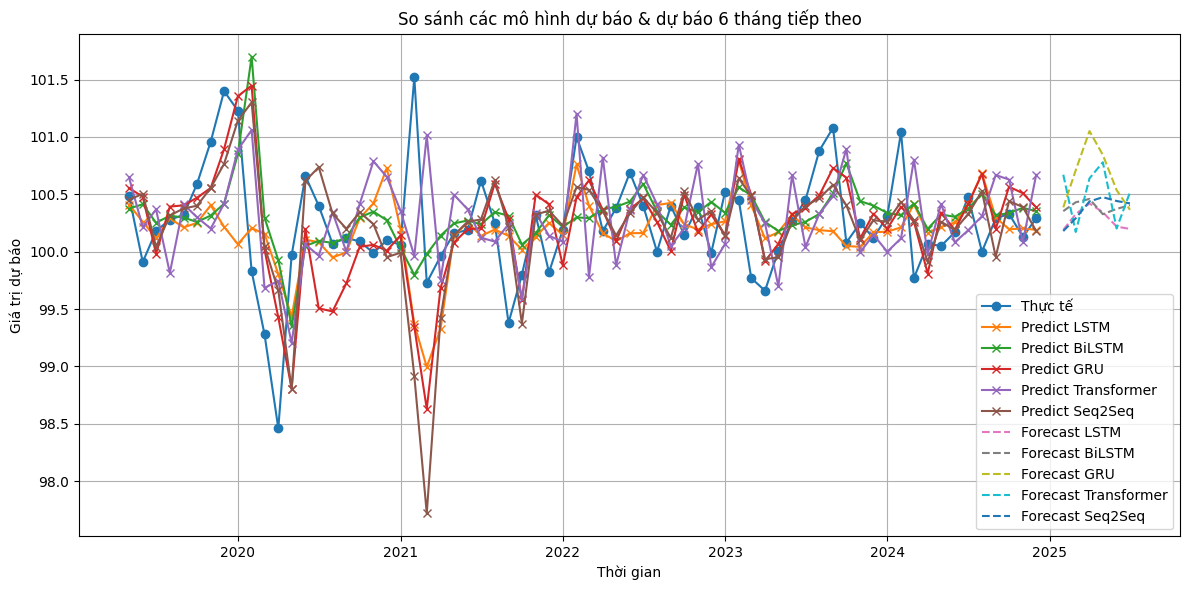

In [ ]:
run_pipeline(data, n_steps=12, activation='swish')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

LSTM Evaluation:
MAE  : 0.3396
MSE  : 0.2414
MAPE : 0.34%
R^2  : -0.0708


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

BiLSTM Evaluation:
MAE  : 0.3626
MSE  : 0.2548
MAPE : 0.36%
R^2  : -0.1303


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

GRU Evaluation:
MAE  : 0.3377
MSE  : 0.2367
MAPE : 0.34%
R^2  : -0.0498


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 12, 32)         │             64 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 12, 32)         │          8,416 │ dense_12[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 12, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 12, 32)         │              0 │ dense_12[0][0],        │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 12, 32)         │             64 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 12, 32)         │          1,056 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 12, 32)         │          1,056 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 12, 32)         │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 12, 32)         │              0 │ layer_normalization_2… │
│                           │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 12, 32)         │             64 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 384)            │              0 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1)              │            385 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Transformer Evaluation:
MAE  : 0.5023
MSE  : 0.3815
MAPE : 0.50%
R^2  : -0.6921


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_5 (GRU)               │ [(None, 50), (None,    │          7,950 │ input_layer_10[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_1           │ (None, 1, 50)          │              0 │ gru_5[0][1]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_6 (GRU)               │ (None, 1, 50)          │         15,300 │ repeat_vector_1[0][0], │
│                           │                        │                │ gru_5[0][1]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 1, 1)           │             51 │ gru_6[0][0]            │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1)              │              0 │ time_distributed_1[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Seq2Seq Evaluation:
MAE  : 0.3743
MSE  : 0.2624
MAPE : 0.37%
R^2  : -0.1641


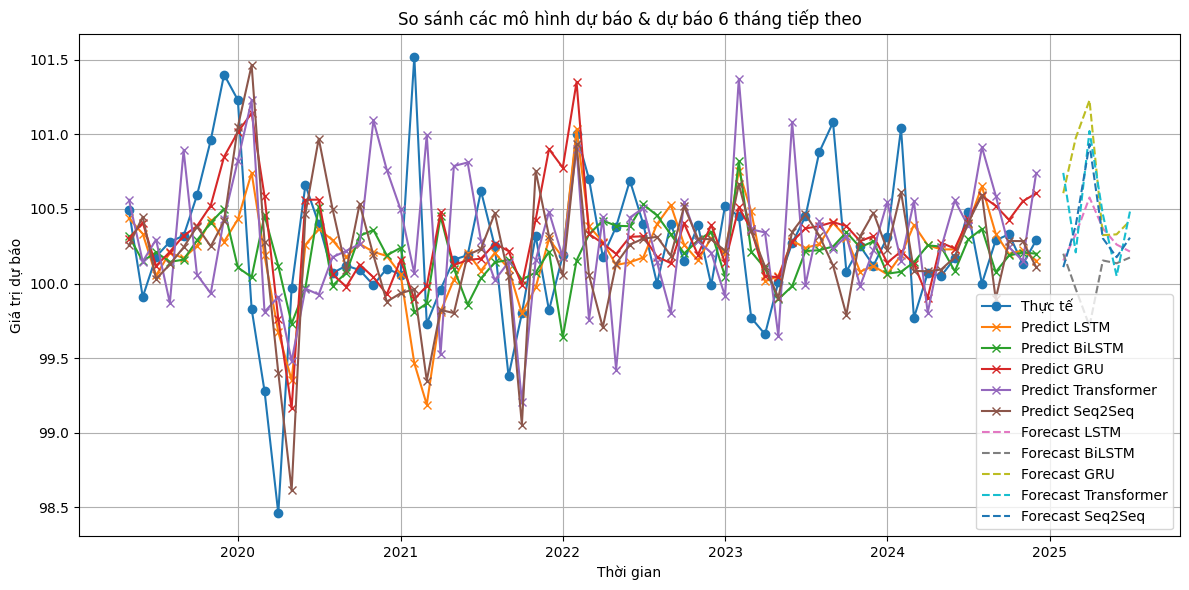

In [ ]:
run_pipeline(data, n_steps=12, activation='tanh')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

LSTM Evaluation:
MAE  : 0.3676
MSE  : 0.2739
MAPE : 0.37%
R^2  : -0.2151


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

BiLSTM Evaluation:
MAE  : 0.3744
MSE  : 0.2574
MAPE : 0.37%
R^2  : -0.1420


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                          │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

GRU Evaluation:
MAE  : 0.3512
MSE  : 0.2360
MAPE : 0.35%
R^2  : -0.0468


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 12, 32)         │             64 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 12, 32)         │          8,416 │ dense_20[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 12, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 12, 32)         │              0 │ dense_20[0][0],        │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 12, 32)         │             64 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 12, 32)         │          1,056 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 12, 32)         │          1,056 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 12, 32)         │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 12, 32)         │              0 │ layer_normalization_4… │
│                           │                        │                │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 12, 32)         │             64 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 384)            │              0 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 1)              │            385 │ flatten_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Transformer Evaluation:
MAE  : 0.4343
MSE  : 0.3050
MAPE : 0.43%
R^2  : -0.3531


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_8 (GRU)               │ [(None, 50), (None,    │          7,950 │ input_layer_15[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 1, 50)          │              0 │ gru_8[0][1]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_9 (GRU)               │ (None, 1, 50)          │         15,300 │ repeat_vector_2[0][0], │
│                           │                        │                │ gru_8[0][1]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 1, 1)           │             51 │ gru_9[0][0]            │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1)              │              0 │ time_distributed_2[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Seq2Seq Evaluation:
MAE  : 0.3972
MSE  : 0.3131
MAPE : 0.40%
R^2  : -0.3887


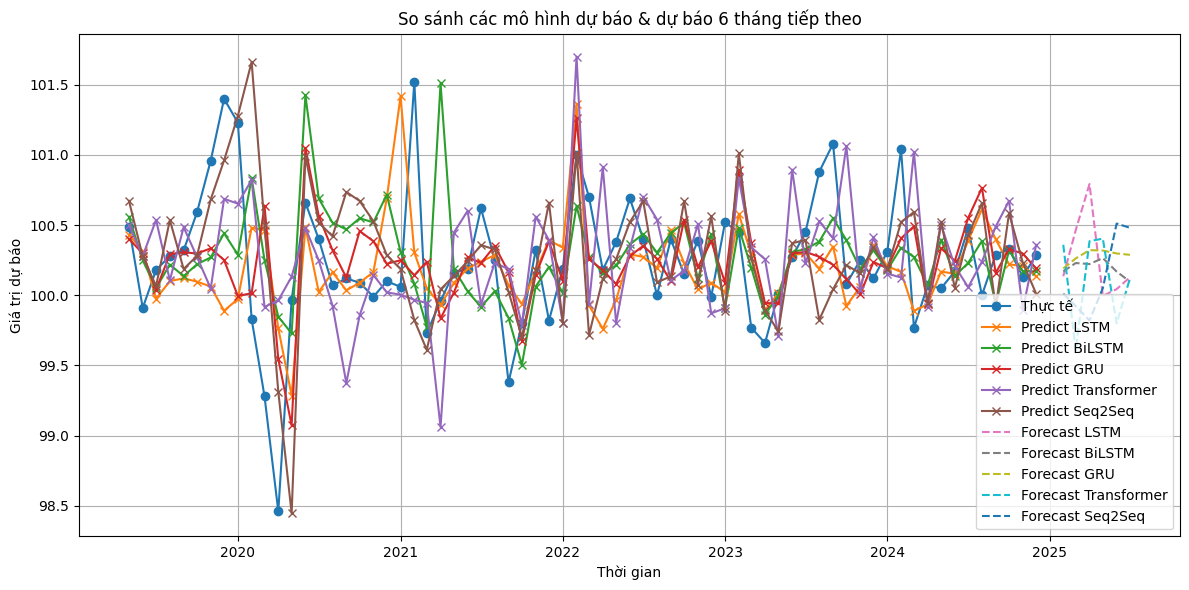

In [ ]:
run_pipeline(data, n_steps=12, activation='relu')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

LSTM Evaluation:
MAE  : 0.3772
MSE  : 0.2721
MAPE : 0.38%
R^2  : -0.1675


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

BiLSTM Evaluation:
MAE  : 0.3725
MSE  : 0.2519
MAPE : 0.37%
R^2  : -0.0806


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

GRU Evaluation:
MAE  : 0.4069
MSE  : 0.2713
MAPE : 0.41%
R^2  : -0.1640


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 24, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 24, 32)         │             64 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 24, 32)         │          8,416 │ dense_28[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 24, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 24, 32)         │              0 │ dense_28[0][0],        │
│                           │                        │                │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 24, 32)         │             64 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 24, 32)         │          1,056 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 24, 32)         │          1,056 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 24, 32)         │              0 │ dense_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 24, 32)         │              0 │ layer_normalization_6… │
│                           │                        │                │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 24, 32)         │             64 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 768)            │              0 │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 1)              │            769 │ flatten_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,469 (134.65 KB)

 Trainable params: 11,489 (44.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,980 (89.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Transformer Evaluation:
MAE  : 0.5552
MSE  : 0.4952
MAPE : 0.55%
R^2  : -1.1245


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 24, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_11 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_20[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_3           │ (None, 1, 50)          │              0 │ gru_11[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_12 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_3[0][0], │
│                           │                        │                │ gru_11[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 1, 1)           │             51 │ gru_12[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1)              │              0 │ time_distributed_3[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Seq2Seq Evaluation:
MAE  : 0.3829
MSE  : 0.3004
MAPE : 0.38%
R^2  : -0.2887


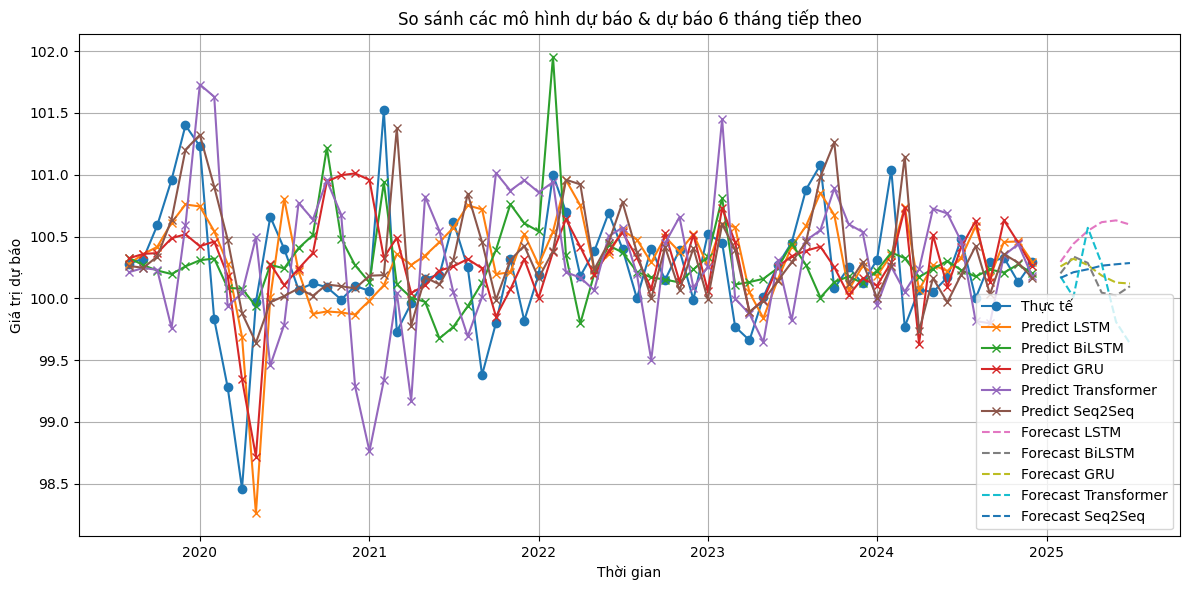

In [ ]:
run_pipeline(data, n_steps=24, activation='swish')

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

LSTM Evaluation:
MAE  : 0.3663
MSE  : 0.2763
MAPE : 0.37%
R^2  : -0.2255


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

BiLSTM Evaluation:
MAE  : 0.3621
MSE  : 0.2778
MAPE : 0.36%
R^2  : -0.2322


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_13 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

GRU Evaluation:
MAE  : 0.3801
MSE  : 0.2874
MAPE : 0.38%
R^2  : -0.2750


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 12, 32)         │             64 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 12, 32)         │          8,416 │ dense_36[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 12, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 12, 32)         │              0 │ dense_36[0][0],        │
│                           │                        │                │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 12, 32)         │             64 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 12, 32)         │          1,056 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 12, 32)         │          1,056 │ dense_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 12, 32)         │              0 │ dense_38[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 12, 32)         │              0 │ layer_normalization_8… │
│                           │                        │                │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 12, 32)         │             64 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 384)            │              0 │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 1)              │            385 │ flatten_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Transformer Evaluation:
MAE  : 0.4508
MSE  : 0.3117
MAPE : 0.45%
R^2  : -0.3827


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_14 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_25[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_4           │ (None, 1, 50)          │              0 │ gru_14[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_15 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_4[0][0], │
│                           │                        │                │ gru_14[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 1, 1)           │             51 │ gru_15[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 1)              │              0 │ time_distributed_4[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Seq2Seq Evaluation:
MAE  : 0.3703
MSE  : 0.3366
MAPE : 0.37%
R^2  : -0.4932


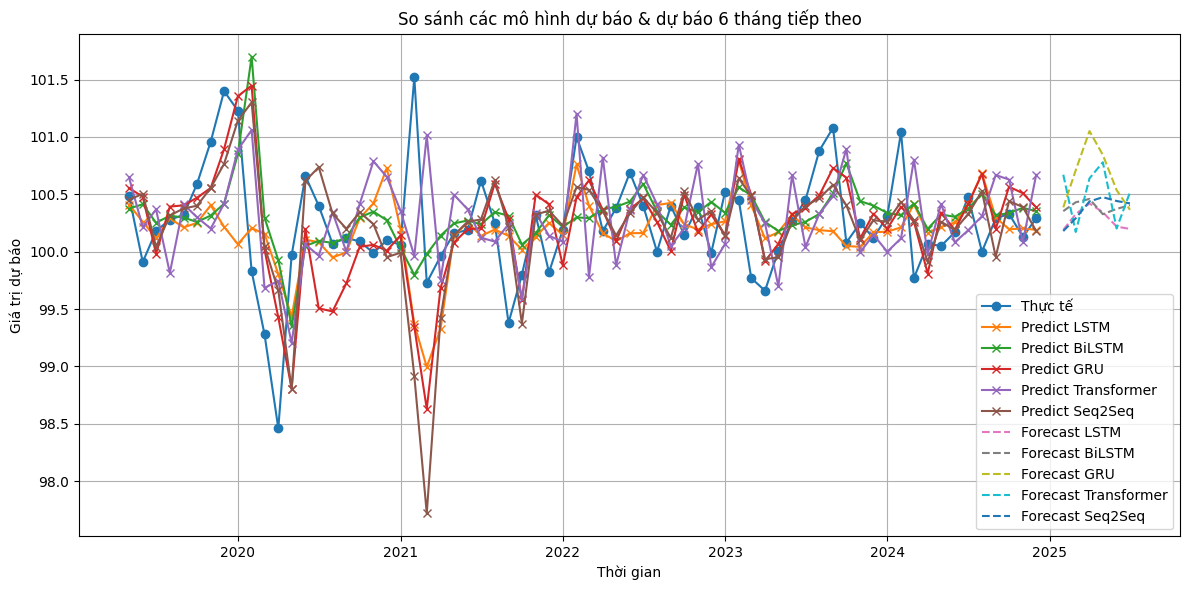

In [ ]:
run_pipeline(data, n_steps=12, activation='swish')

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

LSTM Evaluation:
MAE  : 0.5000
MSE  : 0.4825
MAPE : 0.50%
R^2  : -1.1713


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

BiLSTM Evaluation:
MAE  : 0.4760
MSE  : 0.4274
MAPE : 0.48%
R^2  : -0.9232


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

GRU Evaluation:
MAE  : 0.4096
MSE  : 0.3043
MAPE : 0.41%
R^2  : -0.3693


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29            │ (None, 6, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 6, 32)          │             64 │ input_layer_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 6, 32)          │          8,416 │ dense_44[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 6, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 6, 32)          │              0 │ dense_44[0][0],        │
│                           │                        │                │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 6, 32)          │             64 │ add_10[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 6, 32)          │          1,056 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 6, 32)          │          1,056 │ dense_45[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 6, 32)          │              0 │ dense_46[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 6, 32)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_11    │ (None, 6, 32)          │             64 │ add_11[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 192)            │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_47 (Dense)          │ (None, 1)              │            193 │ flatten_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,741 (127.90 KB)

 Trainable params: 10,913 (42.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,828 (85.27 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Transformer Evaluation:
MAE  : 0.4380
MSE  : 0.3376
MAPE : 0.44%
R^2  : -0.5194


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30            │ (None, 6, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_17 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_30[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_5           │ (None, 1, 50)          │              0 │ gru_17[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_18 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_5[0][0], │
│                           │                        │                │ gru_17[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, 1, 1)           │             51 │ gru_18[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 1)              │              0 │ time_distributed_5[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Seq2Seq Evaluation:
MAE  : 0.3695
MSE  : 0.2706
MAPE : 0.37%
R^2  : -0.2176


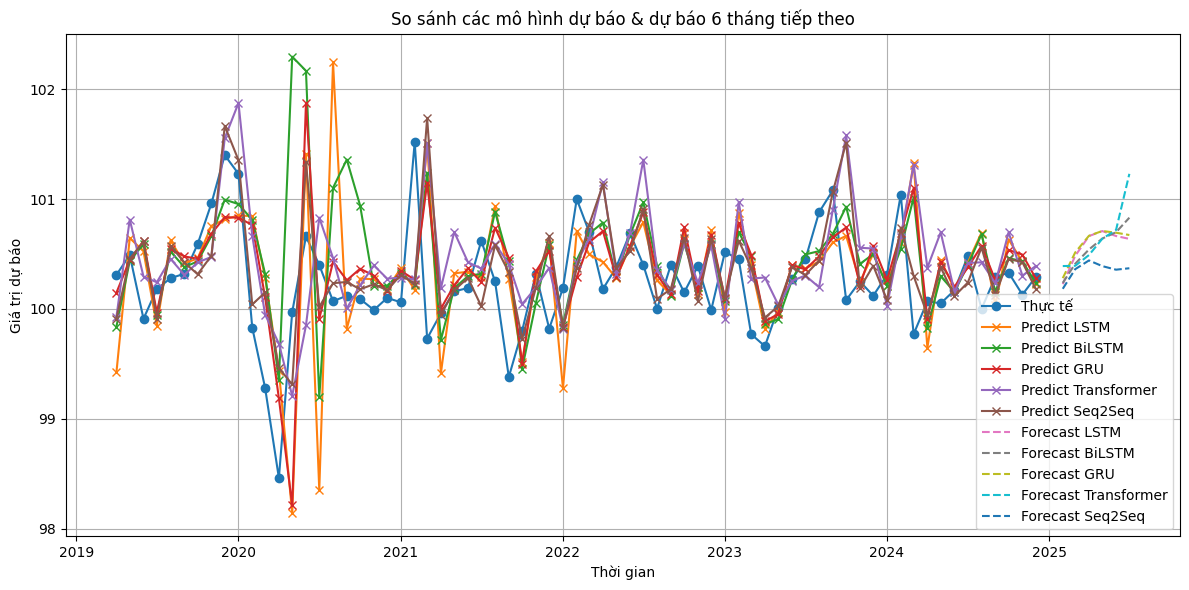

In [ ]:
run_pipeline(data, n_steps=6, activation='swish')

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

LSTM Evaluation:
MAE  : 0.3767
MSE  : 0.2631
MAPE : 0.38%
R^2  : -0.1847


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

BiLSTM Evaluation:
MAE  : 0.3760
MSE  : 0.2767
MAPE : 0.38%
R^2  : -0.2461


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_19 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

GRU Evaluation:
MAE  : 0.3776
MSE  : 0.2643
MAPE : 0.38%
R^2  : -0.1905


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34            │ (None, 3, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 3, 32)          │             64 │ input_layer_34[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_6    │ (None, 3, 32)          │          8,416 │ dense_52[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 3, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 3, 32)          │              0 │ dense_52[0][0],        │
│                           │                        │                │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 3, 32)          │             64 │ add_12[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_53 (Dense)          │ (None, 3, 32)          │          1,056 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_54 (Dense)          │ (None, 3, 32)          │          1,056 │ dense_53[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 3, 32)          │              0 │ dense_54[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 3, 32)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 3, 32)          │             64 │ add_13[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 96)             │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_55 (Dense)          │ (None, 1)              │             97 │ flatten_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,453 (126.77 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,636 (84.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Transformer Evaluation:
MAE  : 0.3955
MSE  : 0.2840
MAPE : 0.39%
R^2  : -0.2792


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35            │ (None, 3, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_20 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_35[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_6           │ (None, 1, 50)          │              0 │ gru_20[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_21 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_6[0][0], │
│                           │                        │                │ gru_20[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_6        │ (None, 1, 1)           │             51 │ gru_21[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 1)              │              0 │ time_distributed_6[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Seq2Seq Evaluation:
MAE  : 0.3502
MSE  : 0.2410
MAPE : 0.35%
R^2  : -0.0854


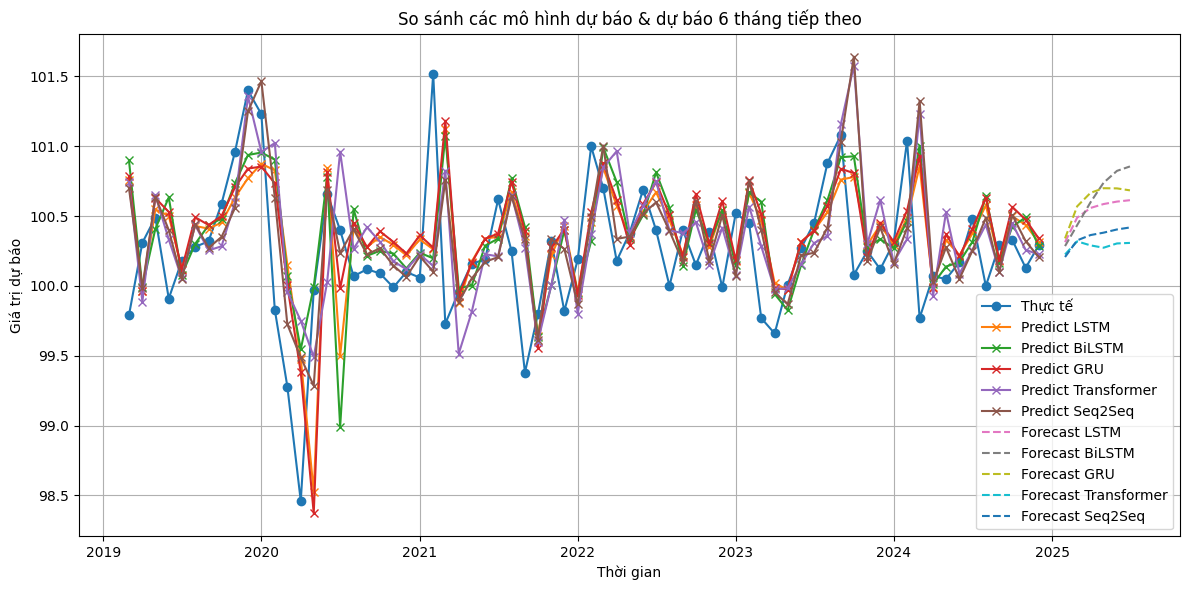

In [ ]:
run_pipeline(data, n_steps=3, activation='swish')

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

LSTM Evaluation:
MAE  : 0.3770
MSE  : 0.2702
MAPE : 0.38%
R^2  : -0.2169


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

BiLSTM Evaluation:
MAE  : 0.3756
MSE  : 0.2600
MAPE : 0.38%
R^2  : -0.1711


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_22 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

GRU Evaluation:
MAE  : 0.3901
MSE  : 0.2769
MAPE : 0.39%
R^2  : -0.2471


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39            │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_60 (Dense)          │ (None, 2, 32)          │             64 │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 2, 32)          │          8,416 │ dense_60[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_60[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 2, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 2, 32)          │              0 │ dense_60[0][0],        │
│                           │                        │                │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 2, 32)          │             64 │ add_14[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_61 (Dense)          │ (None, 2, 32)          │          1,056 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_62 (Dense)          │ (None, 2, 32)          │          1,056 │ dense_61[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 2, 32)          │              0 │ dense_62[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 2, 32)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 2, 32)          │             64 │ add_15[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 64)             │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_63 (Dense)          │ (None, 1)              │             65 │ flatten_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,357 (126.40 KB)

 Trainable params: 10,785 (42.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,572 (84.27 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Transformer Evaluation:
MAE  : 0.3545
MSE  : 0.2441
MAPE : 0.35%
R^2  : -0.0993


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_23 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_40[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_7           │ (None, 1, 50)          │              0 │ gru_23[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_24 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_7[0][0], │
│                           │                        │                │ gru_23[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_7        │ (None, 1, 1)           │             51 │ gru_24[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 1)              │              0 │ time_distributed_7[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Seq2Seq Evaluation:
MAE  : 0.3821
MSE  : 0.2801
MAPE : 0.38%
R^2  : -0.2617


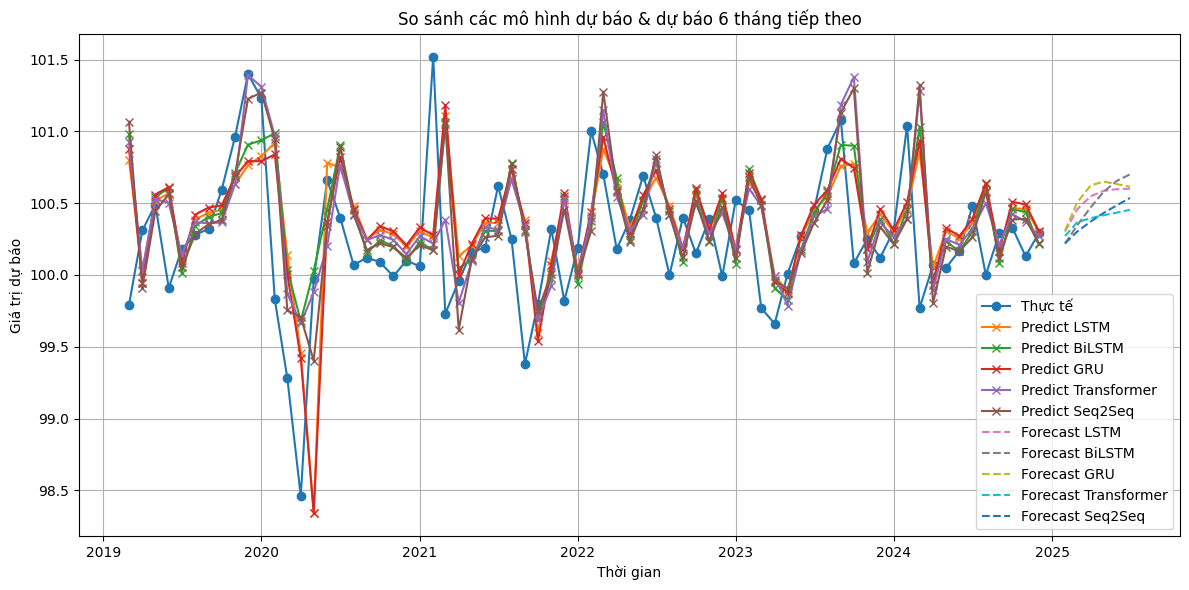

In [ ]:
run_pipeline(data, n_steps=2, activation='swish')

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

LSTM Evaluation:
MAE  : 0.3784
MSE  : 0.2756
MAPE : 0.38%
R^2  : -0.1825


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

BiLSTM Evaluation:
MAE  : 0.4122
MSE  : 0.2955
MAPE : 0.41%
R^2  : -0.2676


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_25 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

GRU Evaluation:
MAE  : 0.3842
MSE  : 0.2815
MAPE : 0.38%
R^2  : -0.2079


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44            │ (None, 24, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_68 (Dense)          │ (None, 24, 32)         │             64 │ input_layer_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 24, 32)         │          8,416 │ dense_68[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_68[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 24, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 24, 32)         │              0 │ dense_68[0][0],        │
│                           │                        │                │ dropout_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 24, 32)         │             64 │ add_16[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_69 (Dense)          │ (None, 24, 32)         │          1,056 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_70 (Dense)          │ (None, 24, 32)         │          1,056 │ dense_69[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 24, 32)         │              0 │ dense_70[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 24, 32)         │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_17    │ (None, 24, 32)         │             64 │ add_17[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 768)            │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_71 (Dense)          │ (None, 1)              │            769 │ flatten_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,469 (134.65 KB)

 Trainable params: 11,489 (44.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,980 (89.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Transformer Evaluation:
MAE  : 0.4781
MSE  : 0.4258
MAPE : 0.48%
R^2  : -0.8268


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_45            │ (None, 24, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_26 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_45[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_8           │ (None, 1, 50)          │              0 │ gru_26[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_27 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_8[0][0], │
│                           │                        │                │ gru_26[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_8        │ (None, 1, 1)           │             51 │ gru_27[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_8 (Lambda)         │ (None, 1)              │              0 │ time_distributed_8[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Seq2Seq Evaluation:
MAE  : 0.3766
MSE  : 0.2462
MAPE : 0.38%
R^2  : -0.0561


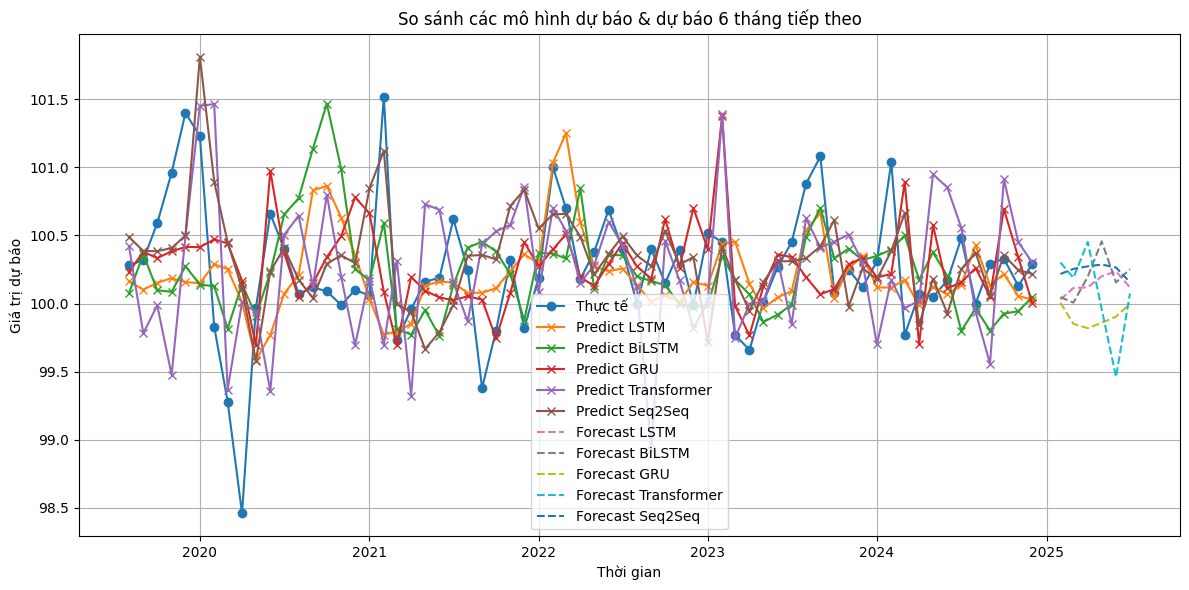

In [ ]:
run_pipeline(data, n_steps=24, activation='tanh')

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

LSTM Evaluation:
MAE  : 0.3396
MSE  : 0.2414
MAPE : 0.34%
R^2  : -0.0708


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

BiLSTM Evaluation:
MAE  : 0.3626
MSE  : 0.2548
MAPE : 0.36%
R^2  : -0.1303


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_28 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

GRU Evaluation:
MAE  : 0.3377
MSE  : 0.2367
MAPE : 0.34%
R^2  : -0.0498


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_76 (Dense)          │ (None, 12, 32)         │             64 │ input_layer_49[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_9    │ (None, 12, 32)         │          8,416 │ dense_76[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_76[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 12, 32)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 12, 32)         │              0 │ dense_76[0][0],        │
│                           │                        │                │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_18    │ (None, 12, 32)         │             64 │ add_18[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_77 (Dense)          │ (None, 12, 32)         │          1,056 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_78 (Dense)          │ (None, 12, 32)         │          1,056 │ dense_77[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 12, 32)         │              0 │ dense_78[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 12, 32)         │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_19    │ (None, 12, 32)         │             64 │ add_19[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 384)            │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_79 (Dense)          │ (None, 1)              │            385 │ flatten_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Transformer Evaluation:
MAE  : 0.5023
MSE  : 0.3815
MAPE : 0.50%
R^2  : -0.6921


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_29 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_50[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_9           │ (None, 1, 50)          │              0 │ gru_29[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_30 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_9[0][0], │
│                           │                        │                │ gru_29[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_9        │ (None, 1, 1)           │             51 │ gru_30[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_9 (Lambda)         │ (None, 1)              │              0 │ time_distributed_9[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Seq2Seq Evaluation:
MAE  : 0.3743
MSE  : 0.2624
MAPE : 0.37%
R^2  : -0.1641


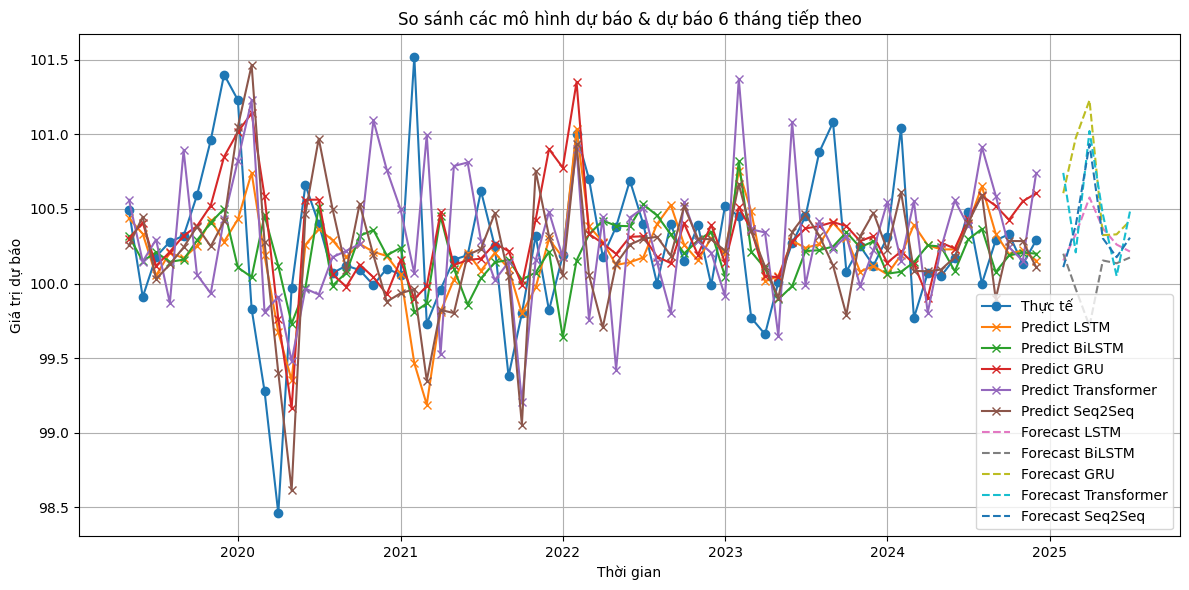

In [ ]:
run_pipeline(data, n_steps=12, activation='tanh')

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

LSTM Evaluation:
MAE  : 0.3744
MSE  : 0.2606
MAPE : 0.37%
R^2  : -0.1728


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_10 (Bidirectional)     │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

BiLSTM Evaluation:
MAE  : 0.3819
MSE  : 0.2904
MAPE : 0.38%
R^2  : -0.3068


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_31 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

GRU Evaluation:
MAE  : 0.3993
MSE  : 0.2747
MAPE : 0.40%
R^2  : -0.2364


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_54            │ (None, 6, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_84 (Dense)          │ (None, 6, 32)          │             64 │ input_layer_54[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_10   │ (None, 6, 32)          │          8,416 │ dense_84[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_84[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 6, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 6, 32)          │              0 │ dense_84[0][0],        │
│                           │                        │                │ dropout_31[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_20    │ (None, 6, 32)          │             64 │ add_20[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_85 (Dense)          │ (None, 6, 32)          │          1,056 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_86 (Dense)          │ (None, 6, 32)          │          1,056 │ dense_85[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 6, 32)          │              0 │ dense_86[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_21 (Add)              │ (None, 6, 32)          │              0 │ layer_normalization_2… │
│                           │                        │                │ dropout_32[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_21    │ (None, 6, 32)          │             64 │ add_21[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 192)            │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_87 (Dense)          │ (None, 1)              │            193 │ flatten_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,741 (127.90 KB)

 Trainable params: 10,913 (42.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,828 (85.27 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Transformer Evaluation:
MAE  : 0.4561
MSE  : 0.3526
MAPE : 0.46%
R^2  : -0.5869


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55            │ (None, 6, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_32 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_55[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_10          │ (None, 1, 50)          │              0 │ gru_32[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_33 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_10[0][0… │
│                           │                        │                │ gru_32[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_10       │ (None, 1, 1)           │             51 │ gru_33[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_10 (Lambda)        │ (None, 1)              │              0 │ time_distributed_10[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Seq2Seq Evaluation:
MAE  : 0.4201
MSE  : 0.3411
MAPE : 0.42%
R^2  : -0.5350


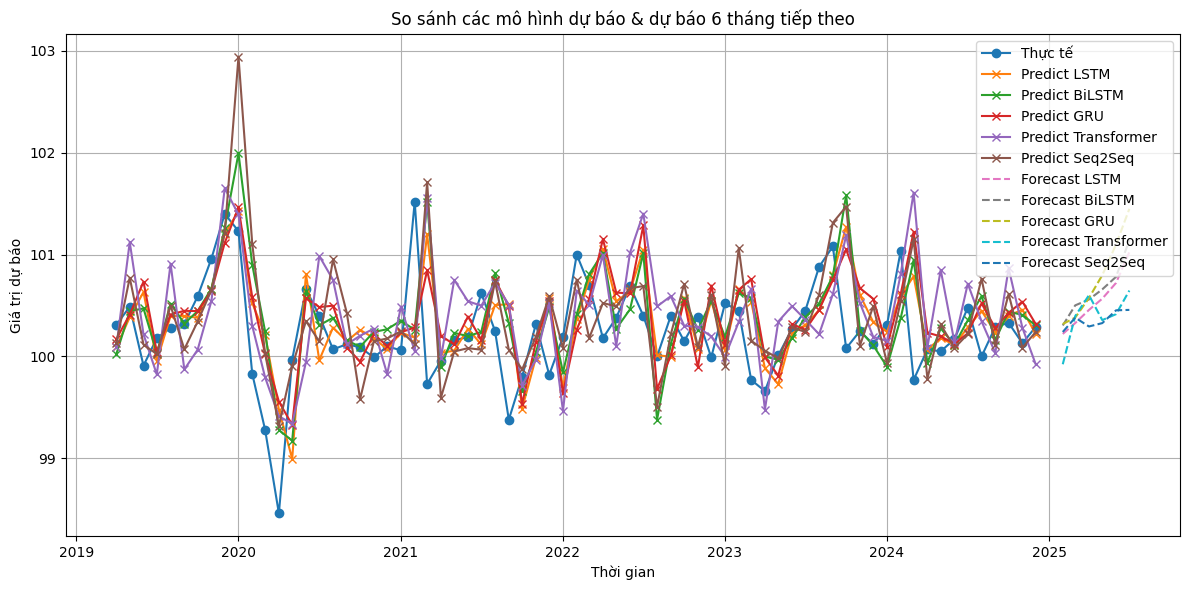

In [ ]:
run_pipeline(data, n_steps=6, activation='tanh')

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

LSTM Evaluation:
MAE  : 0.3709
MSE  : 0.2557
MAPE : 0.37%
R^2  : -0.1515


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_11 (Bidirectional)     │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

BiLSTM Evaluation:
MAE  : 0.3711
MSE  : 0.2657
MAPE : 0.37%
R^2  : -0.1967


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_34 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

GRU Evaluation:
MAE  : 0.3609
MSE  : 0.2420
MAPE : 0.36%
R^2  : -0.0900


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_59            │ (None, 3, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_92 (Dense)          │ (None, 3, 32)          │             64 │ input_layer_59[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_11   │ (None, 3, 32)          │          8,416 │ dense_92[0][0],        │
│ (MultiHeadAttention)      │                        │                │ dense_92[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 3, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_22 (Add)              │ (None, 3, 32)          │              0 │ dense_92[0][0],        │
│                           │                        │                │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_22    │ (None, 3, 32)          │             64 │ add_22[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_93 (Dense)          │ (None, 3, 32)          │          1,056 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_94 (Dense)          │ (None, 3, 32)          │          1,056 │ dense_93[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_35 (Dropout)      │ (None, 3, 32)          │              0 │ dense_94[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_23 (Add)              │ (None, 3, 32)          │              0 │ layer_normalization_2… │
│                           │                        │                │ dropout_35[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_23    │ (None, 3, 32)          │             64 │ add_23[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 96)             │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_95 (Dense)          │ (None, 1)              │             97 │ flatten_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,453 (126.77 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,636 (84.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Transformer Evaluation:
MAE  : 0.3880
MSE  : 0.2815
MAPE : 0.39%
R^2  : -0.2676


Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60            │ (None, 3, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_35 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_60[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_11          │ (None, 1, 50)          │              0 │ gru_35[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_36 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_11[0][0… │
│                           │                        │                │ gru_35[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_11       │ (None, 1, 1)           │             51 │ gru_36[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_11 (Lambda)        │ (None, 1)              │              0 │ time_distributed_11[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

Seq2Seq Evaluation:
MAE  : 0.3432
MSE  : 0.2429
MAPE : 0.34%
R^2  : -0.0940


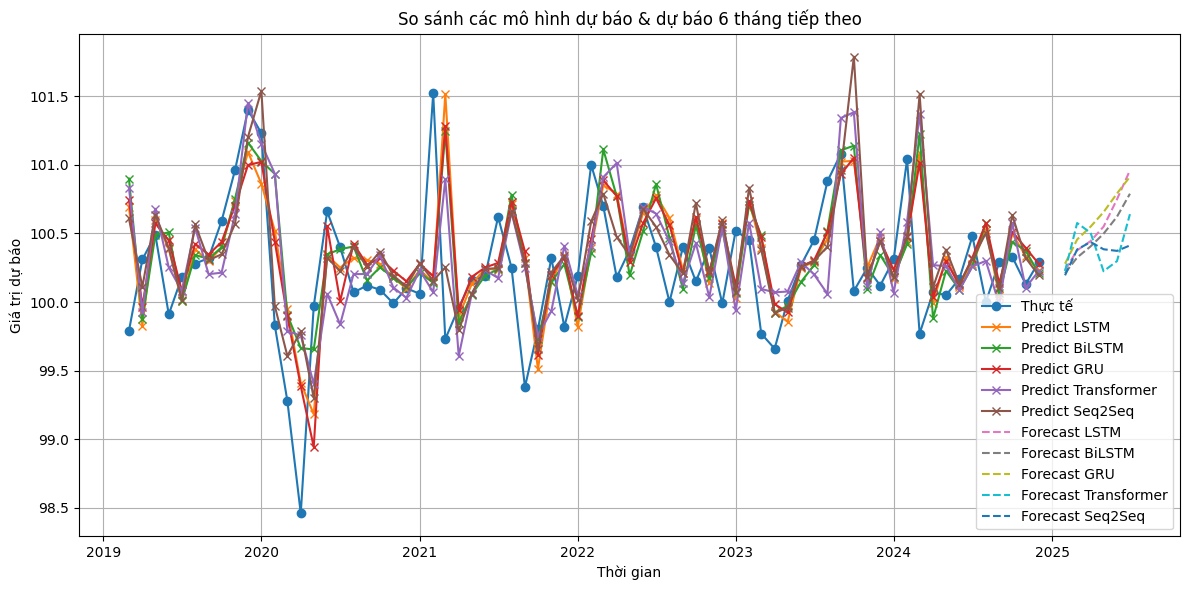

In [ ]:
run_pipeline(data, n_steps=3, activation='tanh')

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

LSTM Evaluation:
MAE  : 0.3948
MSE  : 0.2781
MAPE : 0.39%
R^2  : -0.2525


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_12 (Bidirectional)     │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,705 (244.95 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,804 (163.30 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

BiLSTM Evaluation:
MAE  : 0.3874
MSE  : 0.2802
MAPE : 0.39%
R^2  : -0.2621


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_37 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

GRU Evaluation:
MAE  : 0.3850
MSE  : 0.2649
MAPE : 0.38%
R^2  : -0.1931


Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_64            │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_100 (Dense)         │ (None, 2, 32)          │             64 │ input_layer_64[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_12   │ (None, 2, 32)          │          8,416 │ dense_100[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dense_100[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_37 (Dropout)      │ (None, 2, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 2, 32)          │              0 │ dense_100[0][0],       │
│                           │                        │                │ dropout_37[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_24    │ (None, 2, 32)          │             64 │ add_24[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_101 (Dense)         │ (None, 2, 32)          │          1,056 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_102 (Dense)         │ (None, 2, 32)          │          1,056 │ dense_101[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 2, 32)          │              0 │ dense_102[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 2, 32)          │              0 │ layer_normalization_2… │
│                           │                        │                │ dropout_38[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_25    │ (None, 2, 32)          │             64 │ add_25[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 64)             │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_103 (Dense)         │ (None, 1)              │             65 │ flatten_12[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,357 (126.40 KB)

 Trainable params: 10,785 (42.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,572 (84.27 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Transformer Evaluation:
MAE  : 0.3782
MSE  : 0.2945
MAPE : 0.38%
R^2  : -0.3265


Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_65            │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_38 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_65[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_12          │ (None, 1, 50)          │              0 │ gru_38[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_39 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_12[0][0… │
│                           │                        │                │ gru_38[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_12       │ (None, 1, 1)           │             51 │ gru_39[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_12 (Lambda)        │ (None, 1)              │              0 │ time_distributed_12[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Seq2Seq Evaluation:
MAE  : 0.3684
MSE  : 0.2651
MAPE : 0.37%
R^2  : -0.1937


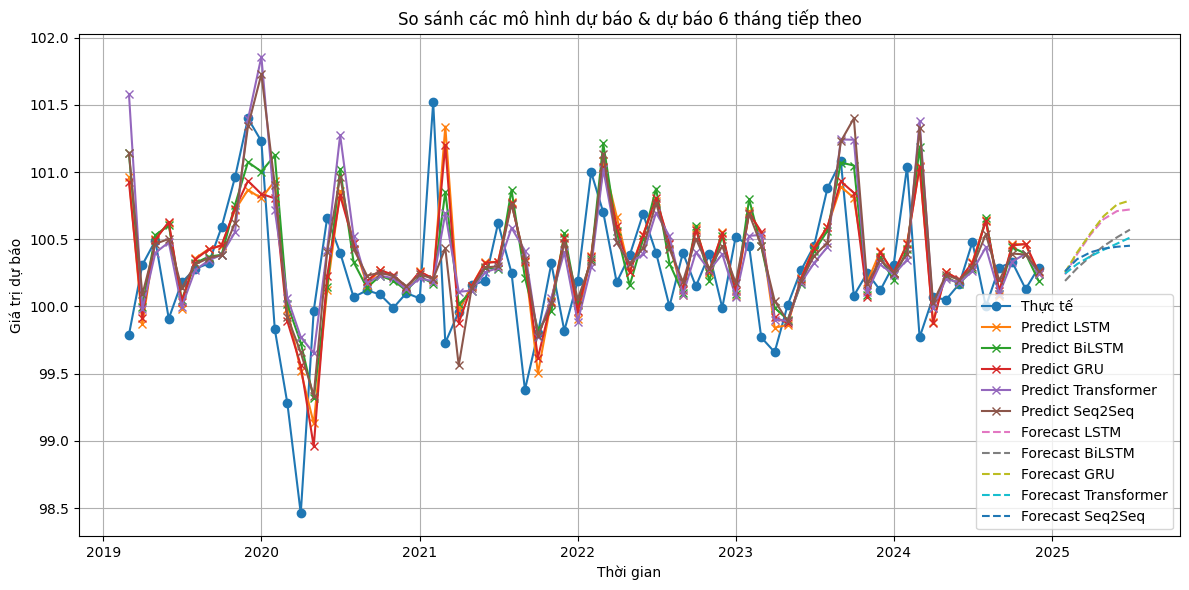

In [ ]:
run_pipeline(data, n_steps=2, activation='tanh')

In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, Dropout, RepeatVector, TimeDistributed, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from bayes_opt import BayesianOptimization
import optuna
from tensorflow.keras.regularizers import l2

# ------------------------- Set seed ------------------------- #
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ------------------------- Preprocessing ------------------------- #
def preprocess_data(data, n_steps=12, scale=True):
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data) if scale else data

    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i - n_steps:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    split = int(len(X) * 0.8)
    return X[:split], X[split:], y[:split], y[split:], scaler

# ------------------------- Cross-Validation ------------------------- #
def cross_val_evaluate(model, X_train, y_train, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32, verbose=0)
        y_pred_fold = model.predict(X_val_fold)
        fold_results.append(mean_squared_error(y_val_fold, y_pred_fold))

    return np.mean(fold_results)

# ------------------------- Evaluation ------------------------- #
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R^2  : {r2:.4f}")

# ------------------------- Tuning ------------------------- #
def tune_model(model_name, builder, X_train, y_train, n_steps):
    def black_box(dropout, latent_dim, num_layers, learning_rate):
        # Create a trial object to pass to the builder function
        class Trial:
            def suggest_float(self, name, low, high):
                if name == 'dropout':
                    return dropout
                return None  # Handle other parameters if needed

            def suggest_int(self, name, low, high):
                if name == 'latent_dim':
                    return int(latent_dim)
                if name == 'num_layers':
                    return int(num_layers)
                return None  # Handle other parameters if needed

            def suggest_categorical(self, name, choices):
                if name == 'activation':
                    return 'swish'  # Fixed activation for simplicity
                return None  # Handle other parameters if needed

        trial = Trial()

        model = builder(trial, n_steps=n_steps) # Pass the trial object
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        model.fit(X_train, y_train, epochs=30, verbose=0)
        loss = model.evaluate(X_train, y_train, verbose=0)
        return -loss

    pbounds = {
        'dropout': (0.1, 0.5),
        'latent_dim': (32, 128),
        'num_layers': (1, 3),
        'learning_rate': (1e-5, 1e-2),
        'units': (16, 256)  # Add units to pbounds
    }

    optimizer = BayesianOptimization(f=black_box, pbounds=pbounds, random_state=42, verbose=0)
    optimizer.maximize(init_points=5, n_iter=10)  # Tăng số vòng lặp
    return optimizer.max

# ------------------------- Model Building ------------------------- #
def build_lstm_model(trial, n_steps):
    units = trial.suggest_int('units', 16, 256)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'swish'])

    model = Sequential()
    model.add(LSTM(units, activation=activation, return_sequences=(num_layers > 1),
                   input_shape=(n_steps, 1), kernel_regularizer=l2(0.001)))
    for _ in range(num_layers - 1):
        model.add(LSTM(units, activation=activation, return_sequences=False,
                       kernel_regularizer=l2(0.001)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    return model

def build_gru_model(trial, n_steps):
    units = trial.suggest_int('units', 16, 256)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'swish'])

    model = Sequential()
    model.add(GRU(units, activation=activation, return_sequences=(num_layers > 1), input_shape=(n_steps, 1)))
    for _ in range(num_layers - 1):
        model.add(GRU(units, activation=activation, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    return model

def build_seq2seq_model(trial, n_steps):
    units = trial.suggest_int('units', 16, 256)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'swish'])

    encoder_inputs = Input(shape=(n_steps, 1))
    _, state_h = GRU(units, activation=activation, return_state=True)(encoder_inputs)
    decoder_inputs = RepeatVector(1)(state_h)
    decoder_outputs = GRU(units, activation=activation, return_sequences=True)(decoder_inputs, initial_state=state_h)
    decoder_outputs = TimeDistributed(Dense(1))(decoder_outputs)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=1))(decoder_outputs)

    model = Model(encoder_inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# ------------------------- Forecasting ------------------------- #
def forecast_future(model, last_data, scaler, steps=6):
    predictions = []
    current_input = last_data.reshape(1, last_data.shape[0], last_data.shape[1])

    for _ in range(steps):
        pred = model.predict(current_input, verbose=0)
        pred_inv = scaler.inverse_transform(pred.reshape(-1, 1))
        predictions.append(pred_inv[0][0])
        new_input = np.append(current_input[0, 1:], pred).reshape(1, last_data.shape[0], last_data.shape[1])
        current_input = new_input

    return predictions

# ------------------------- Plotting ------------------------- #
def plot_results(dates, y_true, predictions_dict, forecasts_dict):
    plt.figure(figsize=(12,6))
    plt.plot(dates, y_true, label='Thực tế', marker='o')
    future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]

    for name, y_pred in predictions_dict.items():
        plt.plot(dates, y_pred, label=f"Predict {name}", marker='x')

    for name, y_forecast in forecasts_dict.items():
        plt.plot(future_dates, y_forecast, '--', label=f"Forecast {name}")

    plt.legend()
    plt.title("So sánh mô hình và dự báo 6 tháng tiếp theo")
    plt.xlabel("Thời gian")
    plt.ylabel("Giá trị")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------- Run Pipeline ------------------------- #
def run_pipeline(data, n_steps=12):
    set_seed()
    X_train, X_test, y_train, y_test, scaler = preprocess_data(data, n_steps)
    y_test_inv = scaler.inverse_transform(y_test)

    model_builders = {
        'LSTM': build_lstm_model,
        'GRU': build_gru_model,
        'Seq2Seq': build_seq2seq_model
    }

    predictions = {}
    forecasts = {}

    for name, builder in model_builders.items():
        print(f"\nTuning {name}...")
        best = tune_model(name, builder, X_train, y_train, n_steps)
        print(f"Best params for {name}:", best)

        # Pass best parameters to model builder
        class Trial:
            def suggest_float(self, name, low, high):
                if name in best['params']:
                    return best['params'][name]
                return None

            def suggest_int(self, name, low, high):
                if name in best['params']:
                    return int(best['params'][name])
                return None

            def suggest_categorical(self, name, choices):
                if name in best['params']:
                    return best['params'][name]
                return None

        trial = Trial()
        model = builder(trial, n_steps=n_steps)

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        model.fit(X_train, y_train, epochs=200, verbose=0, callbacks=[early_stopping])
        y_pred = model.predict(X_test)
        y_pred_inv = scaler.inverse_transform(y_pred)

        predictions[name] = y_pred_inv
        forecasts[name] = forecast_future(model, X_test[-1], scaler)

        evaluate(y_test_inv, y_pred_inv, name)

    plot_results(data.index[-len(y_test):], y_test_inv, predictions, forecasts)

In [ ]:
run_pipeline(data, n_steps=12)


Tuning LSTM...


TypeError: '<=' not supported between instances of 'NoneType' and 'int'

#### Dung mo hinh du doan

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, LayerNormalization, Dropout, MultiHeadAttention, Flatten, RepeatVector, TimeDistributed, Lambda, Bidirectional
import random
import os

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def preprocess_data(data, n_steps=12, scale=True):
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(data) if scale else data

    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i - n_steps:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    split = int(len(X) * 0.8)
    return X[:split], X[split:], y[:split], y[split:], scaler

def build_lstm_model(n_steps, activation='swish'):
    model = Sequential([
        LSTM(50, activation=activation, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm_model(n_steps, activation='swish'):
    model = Sequential([
        Bidirectional(LSTM(50, activation=activation, input_shape=(n_steps, 1))),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(n_steps, activation='swish'):
    model = Sequential([
        GRU(50, activation=activation, input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_transformer_model(n_steps, activation='swish', d_model=32, num_heads=2, ff_dim=32, dropout_rate=0.1):
    inputs = Input(shape=(n_steps, 1))
    x = Dense(d_model, activation=activation)(inputs)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn = Dense(ff_dim, activation=activation)(out1)
    ffn = Dense(d_model)(ffn)
    ffn_output = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    flat = Flatten()(out2)
    outputs = Dense(1)(flat)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def build_seq2seq_model(n_steps, activation='swish', latent_dim=50):
    encoder_inputs = Input(shape=(n_steps, 1))
    _, state_h = GRU(latent_dim, activation=activation, return_state=True)(encoder_inputs)

    decoder_inputs = RepeatVector(1)(state_h)
    decoder_outputs = GRU(latent_dim, activation=activation, return_sequences=True)(decoder_inputs, initial_state=state_h)
    decoder_outputs = TimeDistributed(Dense(1))(decoder_outputs)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=1))(decoder_outputs)

    model = Model(encoder_inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R^2  : {r2:.4f}")

def train_and_predict(model_builder, model_name, X_train, y_train, X_test, scaler, activation):
    model = model_builder(X_train.shape[1], activation)
    model.fit(X_train, y_train, epochs=200, verbose=0)
    model.summary()
    y_pred = model.predict(X_test)
    return model, scaler.inverse_transform(y_pred) # return the trained model

def forecast_future(model, last_data, scaler, steps=6):
    predictions = []
    current_input = last_data.reshape(1, last_data.shape[0], last_data.shape[1])

    for _ in range(steps):
        pred = model.predict(current_input)
        pred_inv = scaler.inverse_transform(pred.reshape(-1, 1))
        predictions.append(pred_inv[0][0])

        new_input = np.append(current_input[0, 1:], pred).reshape(1, last_data.shape[0], last_data.shape[1])
        current_input = new_input

    return predictions

def run_pipeline(data, n_steps=12, activation='swish'):
    set_seed()
    X_train, X_test, y_train, y_test, scaler = preprocess_data(data, n_steps)
    y_test_inv = scaler.inverse_transform(y_test)

    models = {
        'LSTM': build_lstm_model,
        'GRU': build_gru_model,
        'Seq2Seq': build_seq2seq_model
    }

    predictions = {}
    future_forecasts = {}

    for name, builder in models.items():
        model, y_pred = train_and_predict(builder, name, X_train, y_train, X_test, scaler, activation)  # get trained model
        predictions[name] = y_pred
        last_data = X_test[-1]
        future_forecasts[name] = forecast_future(model, last_data, scaler)  # use trained model for forecast

        evaluate(y_test_inv, y_pred, name)

    print(future_forecasts)
    plot_results(data.index[-len(y_test):], y_test_inv, predictions, future_forecasts)

def plot_results(dates, y_true, predictions_dict, forecasts_dict):
    plt.figure(figsize=(12,6))
    plt.plot(dates, y_true, label='Thực tế', marker='o')

    future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]

    for name, y_pred in predictions_dict.items():
        plt.plot(dates, y_pred, label=f"Predict {name}", marker='x')

    for name, y_forecast in forecasts_dict.items():
        plt.plot(future_dates, y_forecast, '--', label=f"Forecast {name}")

    plt.legend()
    plt.title("So sánh các mô hình dự báo & dự báo 6 tháng tiếp theo")
    plt.xlabel("Thời gian")
    plt.ylabel("Giá trị dự báo")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

LSTM Evaluation:
MAE  : 0.3663
MSE  : 0.2763
MAPE : 0.37%
R^2  : -0.2255


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_9 (GRU)                          │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

GRU Evaluation:
MAE  : 0.4066
MSE  : 0.3415
MAPE : 0.41%
R^2  : -0.5147


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_10 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_11[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_3           │ (None, 1, 50)          │              0 │ gru_10[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_11 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_3[0][0], │
│                           │                        │                │ gru_10[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 1, 1)           │             51 │ gru_11[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1)              │              0 │ time_distributed_3[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Seq2Seq Evaluation:
MAE  : 0.3502
MSE  : 0.2377
MAPE : 0.35%
R^2  : -0.0544
{'LSTM': [np.float32(100.190094), np.float32(100.3279), np.float32(100.42066), np.float32(100.344666), np.float32(100.219154), np.float32(100.19873)], 'GRU': [np.float32(100.11802), np.float32(100.32325), np.float32(100.76968), np.float32(100.18243), np.float32(100.16156), np.float32(100.12554)], 'Seq2Seq': [np.float32(100.14757), np.float32(100.227), np.float32(100.32602), np.float32(100.35858), np.float32(100.298836), np.float32(100.25182)]}


<ipython-input-15-29cdcb2c91dd>:150: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]


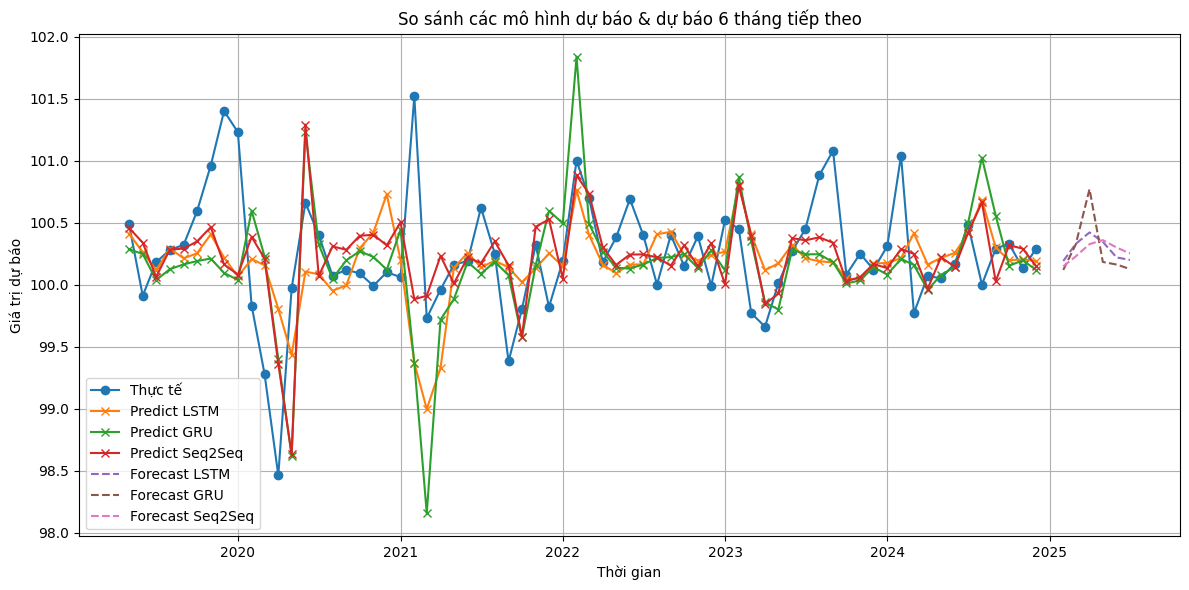

In [ ]:
n_steps=12
run_pipeline(data, n_steps, "swish")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

LSTM Evaluation:
MAE  : 0.3396
MSE  : 0.2414
MAPE : 0.34%
R^2  : -0.0708


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

GRU Evaluation:
MAE  : 0.3767
MSE  : 0.2606
MAPE : 0.38%
R^2  : -0.1559


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_13 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_14[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_4           │ (None, 1, 50)          │              0 │ gru_13[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_14 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_4[0][0], │
│                           │                        │                │ gru_13[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 1, 1)           │             51 │ gru_14[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 1)              │              0 │ time_distributed_4[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Seq2Seq Evaluation:
MAE  : 0.3759
MSE  : 0.3029
MAPE : 0.38%
R^2  : -0.3437
{'LSTM': [np.float32(100.154144), np.float32(100.330284), np.float32(100.576546), np.float32(100.370155), np.float32(100.26127), np.float32(100.2142)], 'GRU': [np.float32(100.33328), np.float32(100.705734), np.float32(101.0855), np.float32(100.23583), np.float32(100.20341), np.float32(100.38777)], 'Seq2Seq': [np.float32(100.17719), np.float32(100.24541), np.float32(100.16328), np.float32(100.2023), np.float32(100.26156), np.float32(100.2851)]}


<ipython-input-15-29cdcb2c91dd>:150: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]


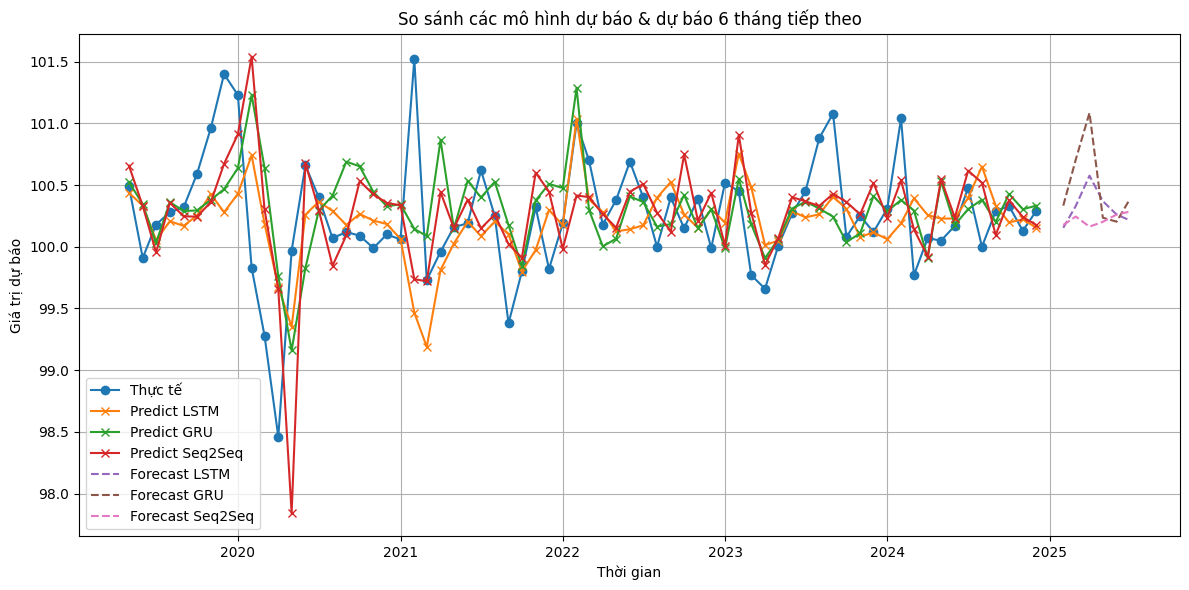

In [ ]:
n_steps=12
run_pipeline(data, n_steps, "tanh")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

LSTM Evaluation:
MAE  : 0.3770
MSE  : 0.2702
MAPE : 0.38%
R^2  : -0.2169


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_15 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

GRU Evaluation:
MAE  : 0.3927
MSE  : 0.2766
MAPE : 0.39%
R^2  : -0.2455


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_16 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_17[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_5           │ (None, 1, 50)          │              0 │ gru_16[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_17 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_5[0][0], │
│                           │                        │                │ gru_16[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, 1, 1)           │             51 │ gru_17[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 1)              │              0 │ time_distributed_5[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Seq2Seq Evaluation:
MAE  : 0.3851
MSE  : 0.2795
MAPE : 0.38%
R^2  : -0.2587
{'LSTM': [np.float32(100.30222), np.float32(100.457115), np.float32(100.54739), np.float32(100.58536), np.float32(100.59759), np.float32(100.60083)], 'GRU': [np.float32(100.29624), np.float32(100.48668), np.float32(100.6062), np.float32(100.63792), np.float32(100.62471), np.float32(100.60878)], 'Seq2Seq': [np.float32(100.21414), np.float32(100.29623), np.float32(100.37041), np.float32(100.44014), np.float32(100.50907), np.float32(100.58104)]}


<ipython-input-15-29cdcb2c91dd>:150: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]


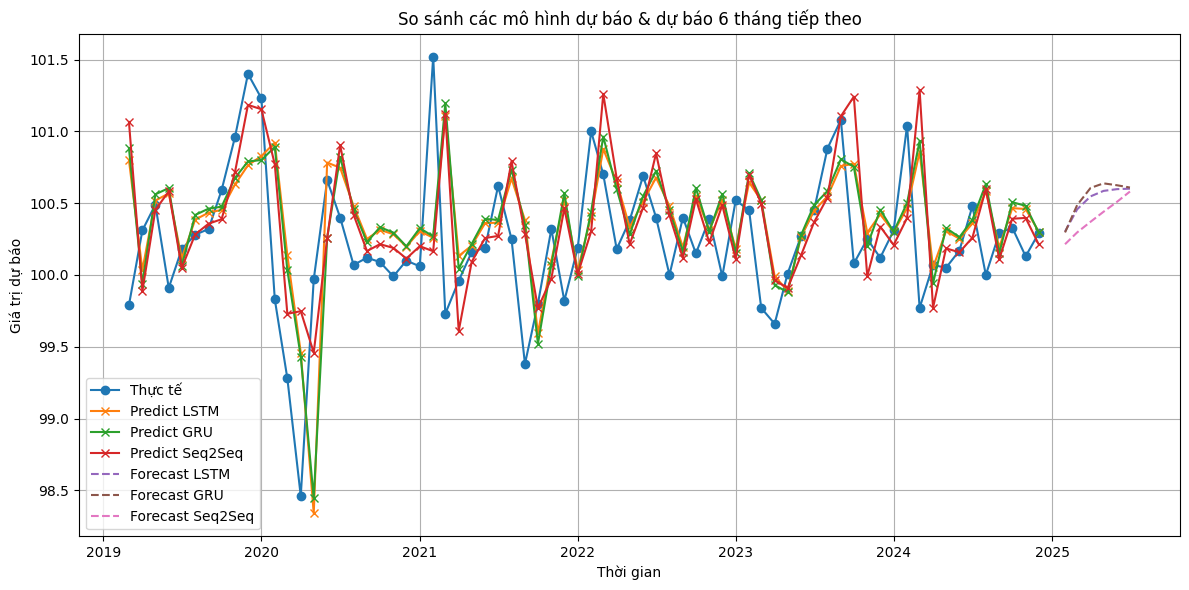

In [ ]:
n_steps=2
run_pipeline(data, n_steps, "swish")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

LSTM Evaluation:
MAE  : 0.3948
MSE  : 0.2781
MAPE : 0.39%
R^2  : -0.2525


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                         │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,005 (93.77 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,004 (62.52 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

GRU Evaluation:
MAE  : 0.3852
MSE  : 0.2623
MAPE : 0.38%
R^2  : -0.1814


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20            │ (None, 2, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_19 (GRU)              │ [(None, 50), (None,    │          7,950 │ input_layer_20[0][0]   │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_6           │ (None, 1, 50)          │              0 │ gru_19[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_20 (GRU)              │ (None, 1, 50)          │         15,300 │ repeat_vector_6[0][0], │
│                           │                        │                │ gru_19[0][1]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_6        │ (None, 1, 1)           │             51 │ gru_20[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 1)              │              0 │ time_distributed_6[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,905 (273.07 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,604 (182.05 KB)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Seq2Seq Evaluation:
MAE  : 0.3721
MSE  : 0.2734
MAPE : 0.37%
R^2  : -0.2312
{'LSTM': [np.float32(100.23858), np.float32(100.39012), np.float32(100.53542), np.float32(100.64962), np.float32(100.70985), np.float32(100.72196)], 'GRU': [np.float32(100.23939), np.float32(100.37715), np.float32(100.50698), np.float32(100.62658), np.float32(100.73114), np.float32(100.80708)], 'Seq2Seq': [np.float32(100.245865), np.float32(100.32177), np.float32(100.37892), np.float32(100.42369), np.float32(100.459694), np.float32(100.4892)]}


<ipython-input-15-29cdcb2c91dd>:150: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(dates[-1], periods=7, freq='M')[1:]


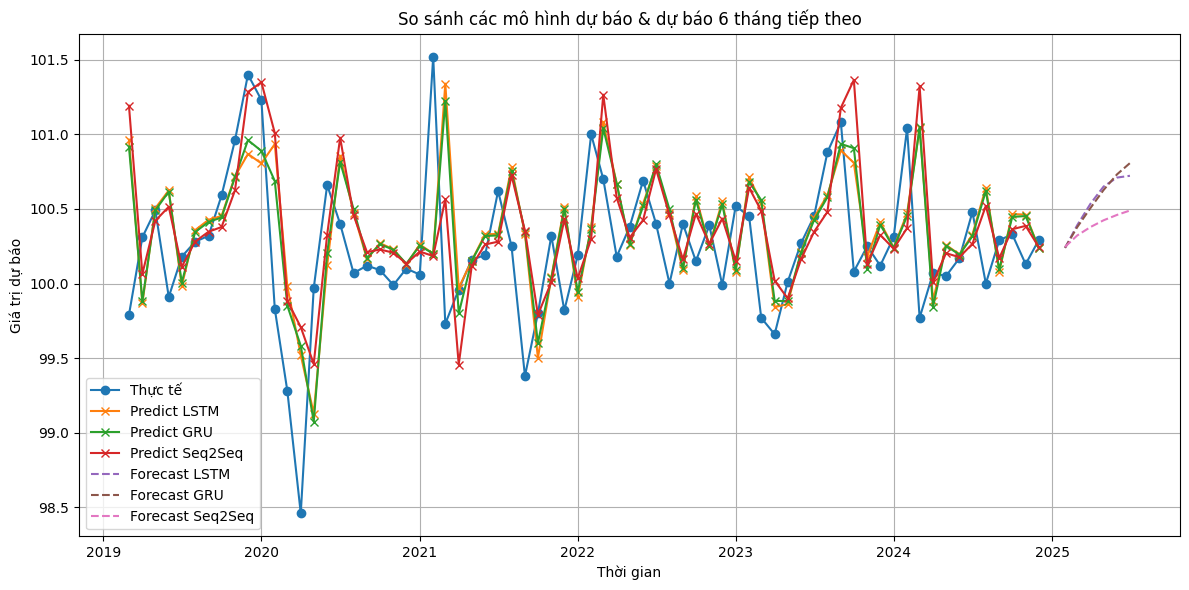

In [ ]:
n_steps=2
run_pipeline(data, n_steps, "tanh")